In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.stats import pearsonr

In [3]:
import utils_plot
import utils_config
from utils_plot import plot_barplot, plot_boxplot

In [4]:
import met_brewer

In [5]:
from matplotlib.lines import Line2D

## Settings

In [6]:
TEXT_WIDTH = 6.7261  # in
DPI = 360

In [7]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

# Settings

In [8]:
sb.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sb.set_palette('colorblind')
set_font_size(20)

# Load data
## Raw data

In [9]:
known_epitopes = [
    'QYIKWPWYI',
    'NYNYLYRLF',
    'LTDEMIAQY',
    'YLQPRTFLL',
    'GILGFVFTL', 
    'SPRRARSVA',
    'CTELKLSDY',
    'AYAQKIFKI',
    'RLQSLQTYV',
    'NLVPMVATV',
    'YVLDHLIVV',
    'FPQSAPHGV',   
    'KCYGVSPTK',
    'TYGPVFMCL'
]

In [10]:
df_data = pd.read_csv('../tcr_benchmark/data/viral.csv', index_col=0)
df_data['In VDJdb'] = df_data['Epitope'].apply(lambda x: 'True' if x in known_epitopes else 'False')
df_data.head()

,CDR3_alpha,CDR3_beta,V_alpha,V_beta,J_alpha,J_beta,Epitope,clone_id,MHC,In VDJdb
0,CAVNAPTGTASKLTF,CASSMRSAVEQYF,TRAV8-1*01,TRBV19*01,TRAJ44*01,TRBJ2-7*01,GILGFVFTL,25.0,HLA-A*02:01,True
1,CAVEGSQGNLIF,CASSMRSAVEQYF,TRAV2*01,TRBV19*01,TRAJ42*01,TRBJ2-7*01,GILGFVFTL,27.0,HLA-A*02:01,True
2,CAGWPGSSNTGKLIF,CASSIRSLAEQYF,TRAV25*01,TRBV19*01,TRAJ37*01,TRBJ2-7*01,GILGFVFTL,34.0,HLA-A*02:01,True
3,CAVRDAILTGGGNKLTF,CASRRQGITETQYF,TRAV3*01,TRBV27*01,TRAJ10*01,TRBJ2-5*01,GILGFVFTL,35.0,HLA-A*02:01,True
4,CATEDNDMRF,CASSFSDTQYF,TRAV17*01,TRBV5-4*01,TRAJ43*01,TRBJ2-3*01,YVLDHLIVV,39.0,HLA-A*02:01,True


In [11]:
df_data['MHC'].value_counts()

MHC
HLA-A*24:02    249
HLA-A*01:01    143
HLA-A*03:01    127
HLA-A*02:01     79
HLA-B*07:02     40
Name: count, dtype: int64

In [12]:
len(df_data)

638

In [13]:
epitopes = df_data['Epitope'].value_counts().index.tolist()
palette_epitopes = met_brewer.met_brew(name='Signac', n=14, brew_type='discrete')
palette_epitopes = dict(zip(epitopes, palette_epitopes))

In [14]:
amount_epis = df_data['Epitope'].value_counts()
amount_epis

Epitope
LTDEMIAQY    129
KCYGVSPTK    127
NYNYLYRLF    116
QYIKWPWYI    114
YLQPRTFLL     49
SPRRARSVA     31
CTELKLSDY     14
GILGFVFTL     13
TYGPVFMCL     10
AYAQKIFKI      9
FPQSAPHGV      9
YVLDHLIVV      6
RLQSLQTYV      6
NLVPMVATV      5
Name: count, dtype: int64

In [15]:
df_data['Epitope'].value_counts()[:4].sum()

486

In [16]:
df_data['Epitope'].value_counts(normalize=True)[:4].sum()

0.7617554858934168

### Databases

In [17]:
iedb = pd.read_csv('../data/processed/iedb.csv', index_col=0)
vdjdb = pd.read_csv('../data/processed/vdjdb.csv', index_col=0)
mcpas = pd.read_csv('../data/processed/mcpas_tcr.csv', index_col=0)
df_all_dbs_paired = pd.concat([iedb, vdjdb, mcpas])[['CDR3_beta', 'CDR3_alpha', 'Epitope']].drop_duplicates()
df_all_dbs_paired = df_all_dbs_paired[df_all_dbs_paired['CDR3_beta'].notna() & df_all_dbs_paired['CDR3_alpha'].notna()]
df_all_dbs_paired = df_all_dbs_paired[df_all_dbs_paired['Epitope'].isin(df_data['Epitope'].unique())]
df_all_dbs_paired['CDR3'] = df_all_dbs_paired['CDR3_alpha'] + '_' + df_all_dbs_paired['CDR3_beta']
df_all_dbs_paired = pd.DataFrame(df_all_dbs_paired.groupby('Epitope')['CDR3'].nunique())

for epi in [el for el in df_data['Epitope'].unique() if not el in df_all_dbs_paired.index]:
    df_all_dbs_paired.loc[epi] = [0]
df_all_dbs_paired
df_all_dbs_paired

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\3817844732.py:1: DtypeWarning: Columns (1,2,3,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  iedb = pd.read_csv('../data/processed/iedb.csv', index_col=0)


,CDR3
Epitope,
AYAQKIFKI,39
CTELKLSDY,77
GILGFVFTL,2116
LTDEMIAQY,135
NLVPMVATV,547
NYNYLYRLF,59
QYIKWPWYI,144
RLQSLQTYV,6
SPRRARSVA,1


In [18]:
iedb = pd.read_csv('../data/processed/iedb.csv', index_col=0)
vdjdb = pd.read_csv('../data/processed/vdjdb.csv', index_col=0)
mcpas = pd.read_csv('../data/processed/mcpas_tcr.csv', index_col=0)
df_all_dbs = pd.concat([iedb, vdjdb, mcpas])
df_all_dbs['CDR3'] = df_all_dbs['CDR3_beta']
df_all_dbs = df_all_dbs[['CDR3', 'Epitope']].drop_duplicates()
df_all_dbs = df_all_dbs[df_all_dbs['CDR3'].notna()]
df_all_dbs = df_all_dbs[df_all_dbs['Epitope'].isin(df_data['Epitope'].unique())]
df_all_dbs = pd.DataFrame(df_all_dbs.groupby('Epitope')['CDR3'].nunique())

for epi in [el for el in df_data['Epitope'].unique() if not el in df_all_dbs.index]:
    df_all_dbs.loc[epi] = [0]
df_all_dbs
df_all_dbs

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\686389424.py:1: DtypeWarning: Columns (1,2,3,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  iedb = pd.read_csv('../data/processed/iedb.csv', index_col=0)


,CDR3
Epitope,
AYAQKIFKI,41
CTELKLSDY,102
GILGFVFTL,7289
KCYGVSPTK,223
LTDEMIAQY,128
NLVPMVATV,6916
NYNYLYRLF,52
QYIKWPWYI,150
RLQSLQTYV,94


In [19]:
df_all_dbs_joint = pd.concat([df_all_dbs, df_all_dbs_paired], axis=1)
df_all_dbs_joint.columns = ['CDR3b', 'CDR3ab']
df_all_dbs_joint

,CDR3b,CDR3ab
Epitope,,
AYAQKIFKI,41,39
CTELKLSDY,102,77
GILGFVFTL,7289,2116
KCYGVSPTK,223,0
LTDEMIAQY,128,135
NLVPMVATV,6916,547
NYNYLYRLF,52,59
QYIKWPWYI,150,144
RLQSLQTYV,94,6


### Performance

In [20]:
path_viral = '../results/results_viral_all_models_and_options.csv'
df_performance_gen = pd.read_csv(path_viral, index_col=0)
df_performance_gen['Metric'] = df_performance_gen['Metric'].replace('AverageRank', 'Rank')
df_performance_gen['BaseModel'] = df_performance_gen['Method'].str.split('_').str[0]
df_performance_gen['Variant'] = df_performance_gen['Method'].str.split('_').str[1:].str.join('_')
df_performance_gen['Group'] = df_performance_gen['Group'].str.split('_HLA').str[0]
df_performance_gen = df_performance_gen[df_performance_gen['Metric'].isin(['Rank', 'R@1', 'R@3', 'AUC', 'APS', 'F1-Score'])]
df_performance_gen.head(5)

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant
0,bertrand,Viral,full_data,638,MPS,Rank,6.923197,bertrand,
1,bertrand,Viral,full_data,638,MPS,R@1,0.072100,bertrand,
2,bertrand,Viral,full_data,638,MPS,R@3,0.429467,bertrand,
5,bertrand,Viral,NLVPMVATV,5,MPS,Rank,12.600000,bertrand,
6,bertrand,Viral,NLVPMVATV,5,MPS,R@1,0.000000,bertrand,


In [21]:
df_performance_gen['Support'].value_counts()

Support
638     2700
14       900
9        360
6        360
5        180
114      180
13       180
10       180
127      180
49       180
129      180
31       180
116      180
8932     180
Name: count, dtype: int64

In [22]:
df_performance_gen['Group'].value_counts()

Group
full_data          360
YLQPRTFLL          360
Average            360
NYNYLYRLF          360
CTELKLSDY          360
YVLDHLIVV          360
SPRRARSVA          360
LTDEMIAQY          360
RLQSLQTYV          360
NLVPMVATV          360
KCYGVSPTK          360
TYGPVFMCL          360
AYAQKIFKI          360
GILGFVFTL          360
FPQSAPHGV          360
QYIKWPWYI          360
WeightedAverage    360
Name: count, dtype: int64

In [23]:
df_performance_gen[(df_performance_gen['Metric']=='AUC')
                  & (df_performance_gen['Group']=='YLQPRTFLL')
                  ].sort_values('Value', ascending=False)

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant
81,teim,Viral,YLQPRTFLL,638,TTP,AUC,0.976751,teim,
81,teinet_SMALL_DS,Viral,YLQPRTFLL,638,TTP,AUC,0.959149,teinet,SMALL_DS
81,tulip-tcr,Viral,YLQPRTFLL,638,TTP,AUC,0.953293,tulip-tcr,
81,teinet_LARGE_DS,Viral,YLQPRTFLL,638,TTP,AUC,0.948754,teinet,LARGE_DS
81,nettcr_t.1.v.0,Viral,YLQPRTFLL,638,TTP,AUC,0.930460,nettcr,t.1.v.0
81,stapler,Viral,YLQPRTFLL,638,TTP,AUC,0.927619,stapler,
81,nettcr_t.0.v.1,Viral,YLQPRTFLL,638,TTP,AUC,0.925332,nettcr,t.0.v.1
81,nettcr_t.4.v.1,Viral,YLQPRTFLL,638,TTP,AUC,0.924327,nettcr,t.4.v.1
81,nettcr_t.0.v.4,Viral,YLQPRTFLL,638,TTP,AUC,0.921243,nettcr,t.0.v.4
81,nettcr_t.4.v.0,Viral,YLQPRTFLL,638,TTP,AUC,0.921243,nettcr,t.4.v.0


In [24]:
df_performance_gen['Group'].value_counts()

Group
full_data          360
YLQPRTFLL          360
Average            360
NYNYLYRLF          360
CTELKLSDY          360
YVLDHLIVV          360
SPRRARSVA          360
LTDEMIAQY          360
RLQSLQTYV          360
NLVPMVATV          360
KCYGVSPTK          360
TYGPVFMCL          360
AYAQKIFKI          360
GILGFVFTL          360
FPQSAPHGV          360
QYIKWPWYI          360
WeightedAverage    360
Name: count, dtype: int64

## Performance categorical

In [25]:
path_viral = '../results/results_viral_categorical_models_option.csv'
df_performance_cat_all = pd.read_csv(path_viral, index_col=0)
df_performance_cat_all['Metric'] = df_performance_cat_all['Metric'].replace('AverageRank', 'Rank')
df_performance_cat_all['Group'] = df_performance_cat_all['Group'].str.split('_HLA').str[0]
df_performance_cat_all['Method'] = df_performance_cat_all['Method'].str.replace('nettcr', 'nettcrcat')
print(len(df_performance_cat_all))
df_performance_cat_all = df_performance_cat_all[df_performance_cat_all['Value'].notna()]
df_performance_cat_all = df_performance_cat_all[df_performance_cat_all['Metric'].isin(
    ['Rank', 'R@1', 'R@3', 'AUC', 'APS', 'F1-Score'])]
print(len(df_performance_cat_all))
df_performance_cat_all.head(5)

3488
1788


,Method,Dataset,Group,Support,Metric_Type,Metric,Value
0,mixtcrpred,Viral,full_data,446,MPS,Rank,3.177130
1,mixtcrpred,Viral,full_data,446,MPS,R@1,0.405830
2,mixtcrpred,Viral,full_data,446,MPS,R@3,0.609865
10,mixtcrpred,Viral,QYIKWPWYI,114,MPS,Rank,4.289474
11,mixtcrpred,Viral,QYIKWPWYI,114,MPS,R@1,0.149123


In [26]:
default_f1 = df_data['Epitope'].value_counts(normalize=True).to_dict()
metric_add = {
    'AUC': 0.5,
    'APS': default_f1,
    'R@1': 0,
    'R@3': 0,
    'F1-Score': default_f1,
    'Rank': {'mixtcrpred': 11.5,
            'tcrgp': 9.5,
            'nettcrcat': 9.5}
}
    
for m, default_value in metric_add.items():
    for method in df_performance_cat_all['Method'].unique():
        for epitope  in df_performance_gen['Group'].unique():
            if epitope in ['full_data', 'Average', 'WeightedAverage']:
                continue
            df_tmp = df_performance_cat_all[(df_performance_cat_all['Metric']==m)
                                            & (df_performance_cat_all['Group']==epitope)
                                            & (df_performance_cat_all['Method']==method)]
            if len(df_tmp) == 0:
                if m in ['F1-Score', 'APS']:
                    default_val = default_value[epitope]
                elif m == 'Rank':
                    default_val = default_value[method.split('_')[0]]
                else:
                    default_val = default_value
                df_add = pd.DataFrame(data={'Method': [method], 'Dataset': ['Viral'], 'Group': [epitope], 'Support': [0], 
                                       'Metric_Type': ['TTP'], 'Metric': [m], 'Value': [default_val]})
                df_performance_cat_all = pd.concat([df_performance_cat_all, df_add], ignore_index=True)

print(len(df_performance_cat_all))
df_performance_cat_all = df_performance_cat_all[~df_performance_cat_all['Group'].isin(['Average', 'WeightedAverage'])]
print(len(df_performance_cat_all))

for model in df_performance_cat_all['Method'].unique():
    for m in metric_add.keys():
        mean = df_performance_cat_all[(df_performance_cat_all['Method']==model)
                                    & (df_performance_cat_all['Group']!='full_data')
                                    & (df_performance_cat_all['Metric']==m)]['Value'].mean()
        df_add = pd.DataFrame(data={'Method': [model], 'Dataset': ['Viral'], 'Group': ['Average'], 'Support': [0], 
                                           'Metric_Type': ['TTP'], 'Metric': [m], 'Value': [mean]})
        df_performance_cat_all = pd.concat([df_performance_cat_all, df_add], ignore_index=True)

df_performance_cat_all['BaseModel'] = df_performance_cat_all['Method'].str.split('_').str[0]
df_performance_cat_all['Variant'] = df_performance_cat_all['Method'].str.split('_').str[1:].str.join('_')
print(len(df_performance_cat_all))
df_performance_cat_all = df_performance_cat_all[~df_performance_cat_all['Metric'].isin(['R@5', 'R@8'])].copy()
df_performance_cat_all.head(5)

4284
3780
4032


,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant
0,mixtcrpred,Viral,full_data,446,MPS,Rank,3.177130,mixtcrpred,
1,mixtcrpred,Viral,full_data,446,MPS,R@1,0.405830,mixtcrpred,
2,mixtcrpred,Viral,full_data,446,MPS,R@3,0.609865,mixtcrpred,
3,mixtcrpred,Viral,QYIKWPWYI,114,MPS,Rank,4.289474,mixtcrpred,
4,mixtcrpred,Viral,QYIKWPWYI,114,MPS,R@1,0.149123,mixtcrpred,


In [27]:
df_performance_cat_all.tail(5)

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant
4027,tcrgp,Viral,Average,0,TTP,APS,0.182324,tcrgp,
4028,tcrgp,Viral,Average,0,TTP,R@1,0.191620,tcrgp,
4029,tcrgp,Viral,Average,0,TTP,R@3,0.282799,tcrgp,
4030,tcrgp,Viral,Average,0,TTP,F1-Score,0.196608,tcrgp,
4031,tcrgp,Viral,Average,0,TTP,Rank,7.216028,tcrgp,


In [28]:
df_per_all = pd.concat([df_performance_gen, df_performance_cat_all])
df_per_all[
    (df_per_all['Metric']=='AUC')
    & (~df_per_all['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
    ].groupby('BaseModel')['Value'].mean().sort_values(ascending=False)

BaseModel
mixtcrpred    0.633323
tulip-tcr     0.624019
teinet        0.602156
stapler       0.598406
nettcr        0.594455
nettcrcat     0.590639
titan         0.583475
tcrgp         0.581138
atm-tcr       0.571870
ergo-ii       0.556538
teim          0.554178
imrex         0.554177
itcep         0.549261
ergo-i        0.544005
bertrand      0.543320
pmtnet        0.533070
dlptcr        0.532628
epitcr        0.517188
attntap       0.501380
tcellmatch    0.497008
panpep        0.491352
Name: Value, dtype: float64

In [29]:
df_per_all[
    (df_per_all['Metric']=='AUC')
    & (~df_per_all['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
    ].groupby('Method')['Value'].mean().sort_values(ascending=False).head(30)

Method
mixtcrpred                      0.633323
tulip-tcr                       0.624019
nettcr_t.1.v.0                  0.613982
teinet_SMALL_DS                 0.611226
nettcr_t.2.v.0                  0.610900
nettcr_t.4.v.0                  0.609590
nettcr_t.0.v.4                  0.609590
nettcr_t.1.v.2                  0.608749
nettcr_t.0.v.2                  0.608437
nettcr_t.0.v.1                  0.607987
nettcr_t.1.v.3                  0.607536
nettcr_t.2.v.1                  0.599403
nettcr_t.3.v.2                  0.599157
nettcrcat_peptide_t.0.v.1       0.598448
stapler                         0.598406
nettcrcat_peptide_t.1.v.0       0.597489
nettcrcat_peptide_t.0.v.4       0.596098
nettcrcat_peptide_t.3.v.0       0.595989
nettcrcat_peptide_t.1.v.4       0.595382
nettcrcat_peptide_t.3.v.2       0.595141
nettcrcat_peptide_t.0.v.3       0.594861
nettcrcat_pretrained_t.2.v.3    0.594499
nettcrcat_peptide_t.3.v.1       0.594441
nettcr_t.3.v.1                  0.594248
nettcrcat

In [30]:
df_per_all[
    (df_per_all['Metric']=='F1-Score')
    & (~df_per_all['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
    ].groupby('Method')['Value'].mean().sort_values(ascending=False).head(50)

Method
mixtcrpred                      0.234261
tcrgp                           0.196608
nettcrcat_pretrained_t.4.v.3    0.189852
nettcrcat_pretrained_t.4.v.1    0.187901
nettcrcat_pretrained_t.3.v.4    0.187826
nettcrcat_pretrained_t.0.v.3    0.187180
nettcrcat_pretrained_t.4.v.2    0.183703
nettcrcat_pretrained_t.1.v.2    0.182548
nettcrcat_pretrained_t.2.v.4    0.182316
nettcrcat_peptide_t.4.v.2       0.181211
nettcrcat_peptide_t.4.v.1       0.180832
nettcrcat_peptide_t.3.v.1       0.175359
nettcrcat_pretrained_t.2.v.3    0.174653
nettcrcat_pretrained_t.0.v.4    0.174242
nettcrcat_pretrained_t.4.v.0    0.173217
nettcrcat_pretrained_t.3.v.0    0.172577
nettcrcat_peptide_t.0.v.3       0.170823
nettcrcat_pretrained_t.3.v.2    0.170693
nettcrcat_peptide_t.4.v.0       0.168129
nettcrcat_peptide_t.1.v.4       0.168015
nettcrcat_pretrained_t.1.v.4    0.166765
nettcrcat_peptide_t.1.v.3       0.166652
nettcrcat_pretrained_t.0.v.2    0.164431
nettcrcat_peptide_t.3.v.0       0.164163
nettcrcat

## Supplementary file

In [31]:
df_performance_all = pd.concat([df_performance_gen, df_performance_cat_all]).reset_index(drop=True)
df_performance_all.to_csv('../supplement/S1_metrics_viral_dataset.csv')

## Select best model Version
If a method provided several models, we will select the one with the best AUC macro-averaged over all epitopes.

In [32]:
best_models = df_performance_all[(df_performance_all['Metric']=='AUC')
                                 & (~df_performance_all['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
                                ].groupby('Method')['Value'].mean()
best_models = pd.DataFrame(best_models.sort_values(ascending=False)).reset_index()
best_models['Name'] = best_models['Method'].str.split('_').str[0]
best_models = best_models.drop_duplicates('Name', keep='first')['Method'].tolist()
best_models

['mixtcrpred',
 'tulip-tcr',
 'nettcr_t.1.v.0',
 'teinet_SMALL_DS',
 'nettcrcat_peptide_t.0.v.1',
 'stapler',
 'ergo-ii_VDJDB',
 'titan',
 'tcrgp',
 'ergo-i_AE_VDJDB',
 'atm-tcr',
 'imrex_FULL',
 'teim',
 'itcep',
 'bertrand',
 'dlptcr_BETA',
 'pmtnet',
 'tcellmatch_LINEAR_CV1',
 'epitcr_WITH_MHC',
 'attntap_VDJDB',
 'panpep']

In [33]:
df_performance_all[(df_performance_all['BaseModel']=='teinet')
                  & (df_performance_all['Metric']=='AUC')
                  & (~df_performance_all['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
                  ].groupby('Variant')['Value'].mean()

Variant
LARGE_DS    0.593086
SMALL_DS    0.611226
Name: Value, dtype: float64

In [34]:
df_performance_best = df_performance_all[df_performance_all['Method'].isin(best_models)].copy()
df_performance_best.head()

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant
0,bertrand,Viral,full_data,638,MPS,Rank,6.923197,bertrand,
1,bertrand,Viral,full_data,638,MPS,R@1,0.072100,bertrand,
2,bertrand,Viral,full_data,638,MPS,R@3,0.429467,bertrand,
3,bertrand,Viral,NLVPMVATV,5,MPS,Rank,12.600000,bertrand,
4,bertrand,Viral,NLVPMVATV,5,MPS,R@1,0.000000,bertrand,


In [35]:
df_performance_best['Group_short'] = df_performance_best['Group'].apply(lambda x: x[:3] 
                                                                        if x not in ['full_data', 'Average', 'WeightedAverage']
                                                                       else x)
df_performance_best['Group_short'].value_counts()

Group_short
full_data          126
YLQ                126
Average            126
NYN                126
CTE                126
YVL                126
SPR                126
LTD                126
RLQ                126
NLV                126
KCY                126
TYG                126
AYA                126
GIL                126
FPQ                126
QYI                126
WeightedAverage    108
Name: count, dtype: int64

In [36]:
df_performance_best[(df_performance_best['Metric']=='F1-Score')
                   & (df_performance_best['Group']=='Average')]

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant,Group_short
100,bertrand,All,Average,14,TTP,F1-Score,0.057265,bertrand,,Average
202,titan,All,Average,14,TTP,F1-Score,0.124058,titan,,Average
304,atm-tcr,All,Average,14,TTP,F1-Score,0.152813,atm-tcr,,Average
406,pmtnet,All,Average,14,TTP,F1-Score,0.118676,pmtnet,,Average
508,teim,All,Average,14,TTP,F1-Score,0.120881,teim,,Average
610,panpep,All,Average,14,TTP,F1-Score,0.093642,panpep,,Average
712,stapler,All,Average,14,TTP,F1-Score,0.146630,stapler,,Average
814,itcep,All,Average,14,TTP,F1-Score,0.124183,itcep,,Average
2242,tcellmatch_LINEAR_CV1,All,Average,14,TTP,F1-Score,0.022214,tcellmatch,LINEAR_CV1,Average
2446,ergo-i_AE_VDJDB,All,Average,14,TTP,F1-Score,0.125504,ergo-i,AE_VDJDB,Average


## Best Model Cat

In [37]:
best_models_cat = df_performance_cat_all[(df_performance_cat_all['Metric']=='AUC')
                                 & (~df_performance_cat_all['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
                                ].groupby('Method')['Value'].mean()
best_models_cat = pd.DataFrame(best_models_cat.sort_values(ascending=False)).reset_index()
best_models_cat['Name'] = best_models_cat['Method'].str.split('_').str[0]
best_models_cat = best_models_cat.drop_duplicates('Name', keep='first')['Method'].tolist()
best_models_cat

['mixtcrpred', 'nettcrcat_peptide_t.0.v.1', 'tcrgp']

In [38]:
df_performance_best_cat = df_performance_cat_all[df_performance_cat_all['Method'].isin(best_models_cat)].copy()
df_performance_best_cat.head()

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant
0,mixtcrpred,Viral,full_data,446,MPS,Rank,3.177130,mixtcrpred,
1,mixtcrpred,Viral,full_data,446,MPS,R@1,0.405830,mixtcrpred,
2,mixtcrpred,Viral,full_data,446,MPS,R@3,0.609865,mixtcrpred,
3,mixtcrpred,Viral,QYIKWPWYI,114,MPS,Rank,4.289474,mixtcrpred,
4,mixtcrpred,Viral,QYIKWPWYI,114,MPS,R@1,0.149123,mixtcrpred,


## Performance Alternative Models

In [39]:
mapper_alt_names = {
    'LSTM_CV0': 'LSTM 0', 
    'LSTM_CV1': 'LSTM 1', 
    'LSTM_CV2': 'LSTM 2', 
    'GRU_CV0': 'GRU 0', 
    'GRU_CV1': 'GRU 1',
    'GRU_CV2': 'GRU 2', 
    'GRU_SEP_CV0': 'GRU-sep 0', 
    'GRU_SEP_CV1': 'GRU-sep 1', 
    'GRU_SEP_CV2': 'GRU-sep 2',
    'LSTM_SEP_CV0': 'LSTM-sep 0', 
    'LSTM_SEP_CV1': 'LSTM-sep 1', 
    'LSTM_SEP_CV2': 'LSTM-sep 2', 
    'LINEAR_CV0': 'Linear 0',
    'LINEAR_CV1': 'Linear 1', 
    'LINEAR_CV2': 'Linear 2', 
    'AE_VDJDB': 'AE VDJdb', 
    'LSTM_VDJDB': 'LSTM VDJdb', 
    'AE_MCPAS': 'AE McPas',
    'LSTM_MCPAS': 'LSTM McPas', 
    'VDJDB': 'VDJdb', 
    'MCPAS': 'McPas', 
    'DOWNSAMPLED': 'Small DS', 
    'FULL': 'Large DS', 
    'LARGE_DS': 'Large DS',
    'SMALL_DS': 'Small DS', 
    'WITH_MHC': 'with MHC', 
    'WO_MHC': 'wo MHC', 
    'ALPHA_BETA': 'Both chains', 
    'ALPHA': 'Alpha', 
    'BETA': 'Beta',
    't.0.v.1': 'T0.V1', 
    't.0.v.2': 'T0.V2', 
    't.0.v.3': 'T0.V3',
    't.0.v.4': 'T0.V4', 
    't.1.v.0': 'T1.V1', 
    't.1.v.2': 'T1.V2',
    't.1.v.3': 'T1.V3', 
    't.1.v.4': 'T1.V4', 
    't.2.v.0': 'T2.V1',
    't.2.v.1': 'T2.V2', 
    't.2.v.3': 'T2.V3', 
    't.2.v.4': 'T2.V4',
    't.3.v.0': 'T3.V0', 
    't.3.v.1': 'T3.V1', 
    't.3.v.2': 'T3.V2',
    't.3.v.4': 'T3.V4', 
    't.4.v.0': 'T4.V0', 
    't.4.v.1': 'T4.V1',
    't.4.v.2': 'T4.V2', 
    't.4.v.3': 'T4.V3',
    'peptide_t.0.v.1': 'T0.V1',
    'peptide_t.0.v.2': 'T0.V2',
    'peptide_t.0.v.3': 'T0.V3',
    'peptide_t.0.v.4': 'T0.V4',
    'peptide_t.1.v.0': 'T1.V0',
    'peptide_t.1.v.2': 'T1.V2',
    'peptide_t.1.v.3': 'T1.V3',
    'peptide_t.1.v.4': 'T1.V4',
    'peptide_t.2.v.0': 'T2.V0',
    'peptide_t.2.v.1': 'T2.V1',
    'peptide_t.2.v.3': 'T2.V3',
    'peptide_t.2.v.4': 'T2.V4',
    'peptide_t.3.v.0': 'T3.V0',
    'peptide_t.3.v.1': 'T3.V1',
    'peptide_t.3.v.2': 'T3.V2',
    'peptide_t.3.v.4': 'T3.V4',
    'peptide_t.4.v.0': 'T4.V0',
    'peptide_t.4.v.1': 'T4.V1',
    'peptide_t.4.v.2': 'T4.V2',
    'peptide_t.4.v.3': 'T4.V3',
    'pretrained_t.0.v.1': 'Pre-T0.V1',
    'pretrained_t.0.v.2': 'Pre-T0.V2',
    'pretrained_t.0.v.3': 'Pre-T0.V3',
    'pretrained_t.0.v.4': 'Pre-T0.V4',
    'pretrained_t.1.v.0': 'Pre-T1.V0',
    'pretrained_t.1.v.2': 'Pre-T1.V2',
    'pretrained_t.1.v.3': 'Pre-T1.V3',
    'pretrained_t.1.v.4': 'Pre-T1.V4',
    'pretrained_t.2.v.0': 'Pre-T2.V0',
    'pretrained_t.2.v.1': 'Pre-T2.V1',
    'pretrained_t.2.v.3': 'Pre-T2.V3',
    'pretrained_t.2.v.4': 'Pre-T2.V4',
    'pretrained_t.3.v.0': 'Pre-T3.V0',
    'pretrained_t.3.v.1': 'Pre-T3.V1',
    'pretrained_t.3.v.2': 'Pre-T3.V2',
    'pretrained_t.3.v.4': 'Pre-T3.V4',
    'pretrained_t.4.v.0': 'Pre-T4.V0',
    'pretrained_t.4.v.1': 'Pre-T4.V1',
    'pretrained_t.4.v.2': 'Pre-T4.V2',
    'pretrained_t.4.v.3': 'Pre-T4.V3'
}

In [40]:
df_performance_alt = df_performance_all[df_performance_all['Variant']!=''].copy()
df_performance_alt['Metric'] = df_performance_alt['Metric'].replace('AverageRank', 'Rank')
df_performance_alt['Variant'] = df_performance_alt['Variant'].map(mapper_alt_names)
df_performance_alt['Method'] = df_performance_alt['BaseModel'] + ' ' + df_performance_alt['Variant']
df_performance_alt.head(5)

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant
816,tcellmatch LSTM 0,Viral,full_data,638,MPS,Rank,7.758621,tcellmatch,LSTM 0
817,tcellmatch LSTM 0,Viral,full_data,638,MPS,R@1,0.083072,tcellmatch,LSTM 0
818,tcellmatch LSTM 0,Viral,full_data,638,MPS,R@3,0.210031,tcellmatch,LSTM 0
819,tcellmatch LSTM 0,Viral,NLVPMVATV,5,MPS,Rank,4.600000,tcellmatch,LSTM 0
820,tcellmatch LSTM 0,Viral,NLVPMVATV,5,MPS,R@1,0.000000,tcellmatch,LSTM 0


## Prediction Score

In [41]:
model_names_score = sorted(df_performance_best['Method'].unique()) #+ sorted(df_performance_best_cat['Method'].unique())

prediction_scores = pd.read_csv(f'../tcr_benchmark/results/predictions_{model_names_score[0]}_viral.csv', index_col=0)
prediction_scores = prediction_scores.drop(columns=['Score'])
for tag in model_names_score:
    df_tmp = pd.read_csv(f'../tcr_benchmark/results/predictions_{tag}_viral.csv', index_col=0)
    prediction_scores[tag] = df_tmp['Score'].values
prediction_scores.head()

,CDR3_alpha,CDR3_beta,V_alpha,V_beta,J_alpha,J_beta,Epitope,clone_id,MHC,Label,...,nettcrcat_peptide_t.0.v.1,panpep,pmtnet,stapler,tcellmatch_LINEAR_CV1,tcrgp,teim,teinet_SMALL_DS,titan,tulip-tcr
0,CAVNAPTGTASKLTF,CASSMRSAVEQYF,TRAV8-1*01,TRBV19*01,TRAJ44*01,TRBJ2-7*01,GILGFVFTL,25.0,HLA-A*02:01,1,...,0.999815,0.675948,0.9510,0.999178,0.894294,0.941194,0.979334,0.999998,0.991495,-0.003135
1,CAVEGSQGNLIF,CASSMRSAVEQYF,TRAV2*01,TRBV19*01,TRAJ42*01,TRBJ2-7*01,GILGFVFTL,27.0,HLA-A*02:01,1,...,0.999997,0.675948,0.9510,0.999480,0.894294,0.941194,0.979334,0.999998,0.991495,-0.001602
2,CAGWPGSSNTGKLIF,CASSIRSLAEQYF,TRAV25*01,TRBV19*01,TRAJ37*01,TRBJ2-7*01,GILGFVFTL,34.0,HLA-A*02:01,1,...,0.999972,0.435693,0.9710,0.998268,0.907589,0.983028,0.986296,1.000000,0.992025,-0.001996
3,CAVRDAILTGGGNKLTF,CASRRQGITETQYF,TRAV3*01,TRBV27*01,TRAJ10*01,TRBJ2-5*01,GILGFVFTL,35.0,HLA-A*02:01,1,...,0.394367,0.395284,0.0640,0.010665,0.864357,0.065932,0.040731,0.115249,0.948033,-2.086307
4,CATEDNDMRF,CASSFSDTQYF,TRAV17*01,TRBV5-4*01,TRAJ43*01,TRBJ2-3*01,GILGFVFTL,39.0,HLA-A*02:01,0,...,0.000103,0.812457,0.9914,0.029653,0.814019,0.337805,0.767383,0.281288,0.877806,-1.959406


In [42]:
prediction_scores.to_csv('../supplement/S2_prediction_scores_viral_dataset.csv')

## Load Predictor Properties

In [43]:
df_properties = pd.read_csv('../data/predictor_properties.csv')
df_properties['Date'] = df_properties['Date_str'].str.split('/').str[1].astype(float)
df_properties['Date'] += df_properties['Date_str'].str.split('/').str[0].astype(float)/12
df_properties['Representation'] = df_properties['Representation'].apply(lambda x: 'Mixed' if '+' in x else x)
df_properties['Network Type'] = df_properties['Network Type'].apply(lambda x: 'Mixed' if '+' in x else x)
df_properties['NegativeRatio'] = df_properties['Negative Pairs'].str.split(':').str[1].str[:-1]
df_properties['Negatives'] = df_properties['Negative Pairs'].str.split(' ').str[0].str.capitalize()
df_properties = df_properties.fillna('None')
df_properties

,Method,Date_str,# Samples,Pretraining,CDR3,Gene Usage,Representation,MHC,Network Type,Negative Pairs,Date,NegativeRatio,Negatives
0,ATM-TCR,07/2022,128142,False,β,False,Embedding,False,Attention,internal (1:1),2022.583333,1,Internal
1,AttnTAP,08/2022,38134,False,β,False,Embedding,False,Mixed,internal (1:1),2022.666667,1,Internal
2,BERTrand,06/2023,32523,True,β,False,Embedding,False,Attention,external (1:3),2023.500000,3,External
3,DLpTCR,08/2021,5710,False,β,False,Mixed,False,Mixed,external (1:1),2021.666667,1,External
4,epiTCR,04/2023,106576,False,β,False,PCP,False,RF,internal (1:30),2023.333333,30,Internal
5,ERGO,07/2019,35201,True,β,False,1-hot,False,MLP,internal (1:5),2019.583333,5,Internal
6,ERGO-II,04/2021,34886,False,α+β,True,1-hot,True,MLP,internal (1:5),2021.333333,5,Internal
7,ImRex,12/2020,14188,False,β,False,PCP,False,CNN,internal (1:1),2021.000000,1,Internal
8,iTCep,05/2023,10759,False,β,False,PCP,False,CNN,external (1:1),2023.416667,1,External
9,NetTCR-2.2,10/2023,9065,False,α+β,CDR1-2,PCP,False,CNN,internal (1:5),2023.833333,5,Internal


# Plotting functions

In [44]:
from matplotlib.patches import Patch
color_known = '#798897'
color_unknown = 'salmon'

In [45]:
epitope_2_mhc = df_data[['Epitope', 'MHC']].drop_duplicates()
epitope_2_mhc = dict(zip(epitope_2_mhc['Epitope'], epitope_2_mhc['MHC'])) 

In [46]:
mhc_colors = met_brewer.met_brew(name="Isfahan2", n=5, brew_type="discrete")  # sb.color_palette('deep')
mhc_colors = {
    'HLA-A*02:01': mhc_colors[0],  #mhc_colors[0], 
    'HLA-A*24:02': mhc_colors[1],  #mhc_colors[1], 
    'HLA-A*03:01': mhc_colors[2],  #mhc_colors[2], 
    'HLA-A*01:01': mhc_colors[3],  #mhc_colors[5],
    'HLA-B*07:02': mhc_colors[4],  #mhc_colors[4]
}
epitope_mhc_colors = {e: mhc_colors[m] for e, m in epitope_2_mhc.items()}

In [47]:
epitopes_beamt = ['GILGFVFTL', 'YVLDHLIVV', 'NLVPMVATV', 'TYGPVFMCL', 'AYAQKIFKI']

In [48]:
np.sum(df_data['Epitope'].isin(epitopes_beamt))

43

In [49]:
np.sum(~df_data['Epitope'].isin(epitopes_beamt))

595

In [50]:
df_data['Epitope'].nunique()

14

In [51]:
separtors_levels = {
    'high': 3.5,
    'medium': 10.5,
    'low': -1
}

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\2187015965.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.barplot(data=df_tmp, x='Epitope', y='# TCRs', palette=epitope_mhc_colors, order=order,


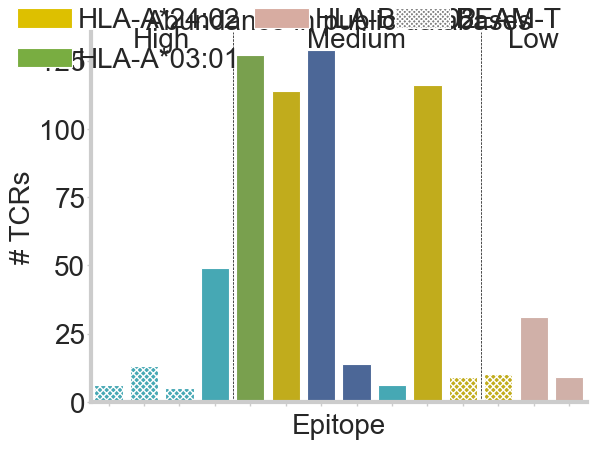

In [52]:
def plot_epitopes(ax=None):
    df_tmp = pd.DataFrame(df_data['Epitope'].value_counts())
    df_tmp['In VDJdb'] = df_tmp.index.map(lambda x: color_known if x in known_epitopes else color_unknown)
    df_tmp = df_tmp.rename(columns={'count': '# TCRs'})
    df_tmp['Epitope'] = df_tmp.index
    
    order = df_all_dbs.sort_values('CDR3', ascending=False).index.tolist()
    plot = sb.barplot(data=df_tmp, x='Epitope', y='# TCRs', palette=epitope_mhc_colors, order=order,
                     ax=ax)    
    labels = [el.get_text() for el in plot.get_xticklabels()]
    plot.set_xticklabels([])
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.spines['left'].set_linewidth(utils_plot.LINEWIDTH)
    plot.spines['bottom'].set_linewidth(utils_plot.LINEWIDTH)
    
    custom_legend = [Patch(facecolor=c, label=l) for l, c in mhc_colors.items()]
    legend2 = plot.legend(handles=custom_legend, ncols=2, frameon=False, title='MHC',
                          columnspacing=0.5, handletextpad=0.2,
                         loc='upper left', bbox_to_anchor=(-0.2, 1.35))
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)
    plot.set_ylabel('# TCRs', labelpad=2)
    
    for i, bar in enumerate(plot.patches):
        if labels[i] in epitopes_beamt:
            bar.set_hatch('xxxxx')
            
    hatch_description = {'Kocher et al.': None, 'BEAM-T': 'xxxxxxx'}
    custom_legend_2 = [Patch(facecolor='gray', label=l, hatch=h) for l, h in hatch_description.items()]
    legend1 = plot.legend(handles=custom_legend_2, frameon=False, title='Dataset',
                          columnspacing=0.5, handletextpad=0.2,
                          loc='upper right', bbox_to_anchor=(1.1, 1.35))
    plot.add_artist(legend1)
    plot.add_artist(legend2)
    
    for name, level in separtors_levels.items():
        if level > 0:
            plot.axvline(level, linestyle='--', color='black', linewidth=0.5)
            
    plot.set_title('Abundance in public databases', pad=2)
    
    groups = {
        'High': 1.5,
        'Medium': 7,
        'Low': 12,
    }
    for name, x in groups.items():
        plot.text(s=name, x=x, y=0.96, horizontalalignment='center', #weight='bold',
                 transform=plot.get_xaxis_transform())
plot_epitopes()

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\2757704567.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.boxplot(data=df_tmp, x='Group', y='Value', ax=ax, order=order,
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\2757704567.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels([el.get_text()[:3] for el in plot.get_xticklabels()], rotation=90)


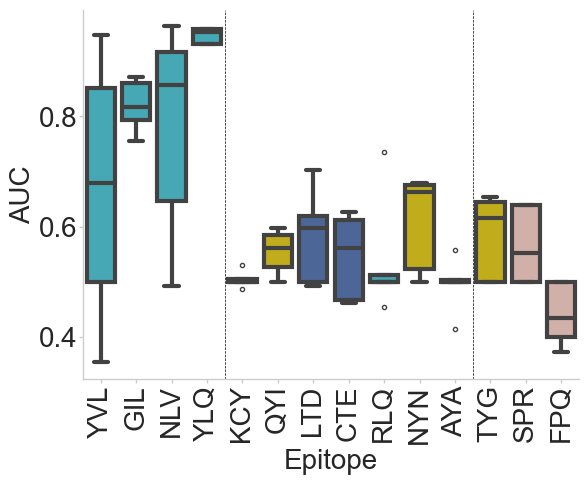

In [53]:
def plot_metric_by_epitope(df, metric, n_top=None, ax=None):
    df_tmp = df[df['Metric']==metric]
    if n_top:
        best_models = df_tmp[df_tmp['Group']=='Average'].sort_values('Value')['BaseModel'][-n_top:].values
        df_tmp = df_tmp[df_tmp['BaseModel'].isin(best_models)]

    df_tmp = df_tmp[~df_tmp['Group'].isin(['Average', 'WeightedAverage', 'full_data'])]
    #order = df_data['Epitope'].value_counts().index.tolist()
    order = df_all_dbs.sort_values('CDR3', ascending=False).index.tolist()
    plot = sb.boxplot(data=df_tmp, x='Group', y='Value', ax=ax, order=order,
                      palette=epitope_mhc_colors,
                      capprops = {"linewidth": utils_plot.LINEWIDTH},
                      flierprops={'markersize': 3},
                      medianprops = {'linewidth': utils_plot.LINEWIDTH},
                      boxprops={"linewidth": utils_plot.LINEWIDTH},
                      whiskerprops = {"linewidth": utils_plot.LINEWIDTH},)
    
    plot.set_xticklabels([el.get_text()[:3] for el in plot.get_xticklabels()], rotation=90)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.set_ylabel(metric, labelpad=2)
    plot.set_xlabel('Epitope')
    
    for name, level in separtors_levels.items():
        if level > 0:
            plot.axvline(level, linestyle='--', color='black', linewidth=0.5)

plot_metric_by_epitope(df_performance_best, 'AUC', 5)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.5176321251707091


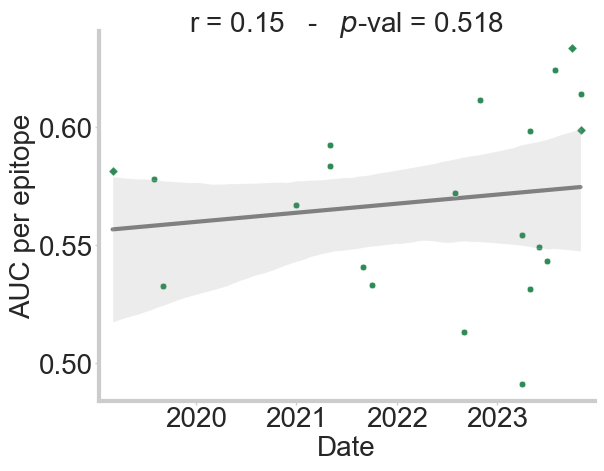

In [54]:
def plot_property_vs_performance(prop, metric, ax=None, size=None):
    df_scores = df_performance_best.copy()
    df_scores['Type'] = df_scores['BaseModel'].apply(lambda x: 'Categorical' if x in ['mixtcrpred', 'nettcrcat', 'tcrgp'] else 'General')
    df_scores = df_scores[df_scores['Metric']==metric]
    df_scores = df_scores[df_scores['Group']=='Average'].set_index('BaseModel')[['Value', 'Type']]
    df_scores.index = df_scores.index.map(utils_config.mapper_methods)
    
    df_props = df_properties.set_index('Method')[[prop]]
    df_combined = pd.concat([df_scores, df_props], axis=1).fillna(0)

    for style in df_combined['Type'].unique():
        plot = sb.scatterplot(data=df_combined[df_combined['Type']==style], x=prop, y='Value',
                              marker='o' if style == 'General' else 'D',
                              s=size if style == 'General' or size==None else size-7, color='seagreen', ax=ax)
    plot = sb.regplot(data=df_combined, 
                      x=prop, y='Value',
                      color='gray', ax=ax, 
                      scatter=False, line_kws={'zorder': -1, 'linewidth': utils_plot.LINEWIDTH})
    
    delta = df_combined[prop].max() - df_combined[prop].min()
    plot.set_xlim(df_combined[prop].min()-0.03*delta, df_combined[prop].max()+0.03*delta,)
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.spines['left'].set_linewidth(utils_plot.LINEWIDTH)
    plot.spines['bottom'].set_linewidth(utils_plot.LINEWIDTH)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)
    plot.set_ylabel(f'{metric} per epitope', labelpad=2)
    plot.set_xlabel(prop, labelpad=2)
    plot.legend().remove()
    
    corr, p_val = pearsonr(df_combined[prop].values, df_combined['Value'].values)
    print(p_val)
    plot.set_title(f'r = {corr:.2f}   -   $p$-val = {p_val:.3f}', pad=0)
    
plot_property_vs_performance('Date', 'AUC')

In [55]:
markers_epitope = {    
    'GILGFVFTL': 'o', 
    'YVLDHLIVV': 's',
    'NLVPMVATV': '^', 
    'YLQPRTFLL': 'v', 
    'RLQSLQTYV': 'p',
    
    'QYIKWPWYI': 'o', 
    'NYNYLYRLF': 's',
    'AYAQKIFKI': '^', 
    'TYGPVFMCL': 'p', 
    
    'LTDEMIAQY': 'o', 
    'CTELKLSDY': 's', 
    
    'SPRRARSVA': 'o', 
    'FPQSAPHGV': 's',
    
    'KCYGVSPTK': 'o',
}

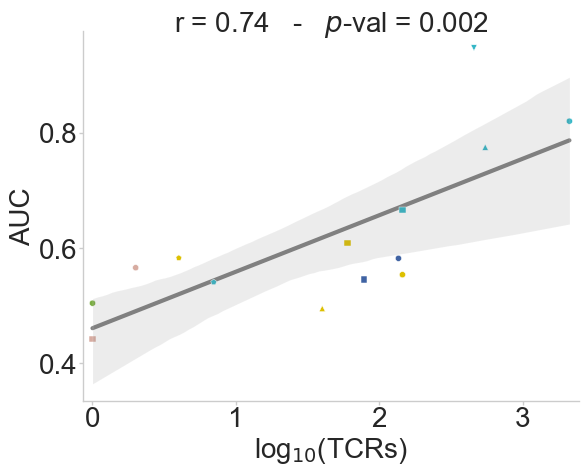

In [56]:
def plot_dbs_vs_performance(df, metric, n_top=5, df_reference=df_all_dbs, ax=None):
    df_tmp = df[df['Metric']==metric]
    if n_top:
        best_models = df_tmp[df_tmp['Group']=='Average'].sort_values('Value')['BaseModel'][-n_top:].values
        df_tmp = df_tmp[df_tmp['BaseModel'].isin(best_models)]
    
    df_tmp = df_tmp[~df_tmp['Group'].isin(['Average', 'WeightedAverage', 'full_data'])]
    df_tmp = df_tmp.groupby('Group')['Value'].mean()
    df_tmp = pd.DataFrame(df_tmp)
    df_tmp = pd.concat([df_tmp, df_reference], axis=1).fillna(0)
    df_tmp['log(TCRs)'] = np.log10(1+df_tmp['CDR3'])
    df_tmp['Epitope'] = df_tmp.index

 
    plot = sb.scatterplot(data=df_tmp, x='log(TCRs)', y='Value',
                          hue='Epitope', style='Epitope',
                          palette=epitope_mhc_colors, markers=markers_epitope,
                         s=20, color='seagreen', ax=ax)
    df_tmp = df_tmp.copy()
    plot = sb.regplot(data=df_tmp, x='log(TCRs)', y='Value',
                      color='gray', ax=ax, scatter=False, line_kws={'zorder': -1, 
                                                                    'linewidth': utils_plot.LINEWIDTH})
    delta = df_tmp['log(TCRs)'].max() - df_tmp['log(TCRs)'].min()
    plot.set_xlim(df_tmp['log(TCRs)'].min()-0.02*delta, df_tmp['log(TCRs)'].max()+0.02*delta,)
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.set_ylabel(metric, labelpad=2)
    plot.set_xlabel('log$_{10}$(TCRs)', labelpad=2)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)
    plot.legend().remove()
    
    corr, p_val = pearsonr(df_tmp['log(TCRs)'].values, df_tmp['Value'].values)
    plot.set_title(f'r = {corr:.2f}   -   $p$-val = {p_val:.3f}', pad=0)
    
plot_dbs_vs_performance(df_performance_best, 'AUC', 5, df_all_dbs_paired)

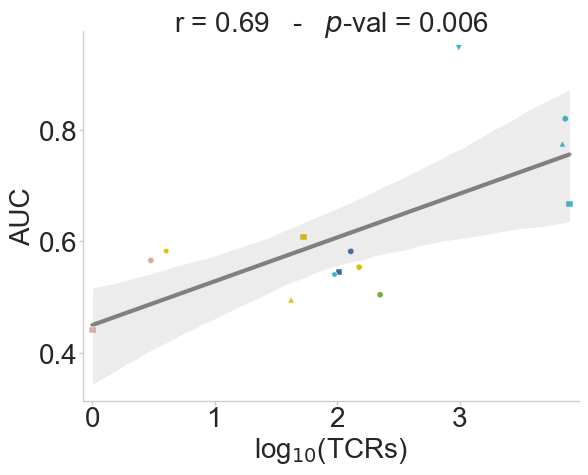

In [57]:
plot_dbs_vs_performance(df_performance_best, 'AUC', 5, df_all_dbs)

In [58]:
df_performance_best['BaseModel'].value_counts()

BaseModel
bertrand      102
titan         102
nettcr        102
tulip-tcr     102
attntap       102
dlptcr        102
epitcr        102
teinet        102
imrex         102
ergo-ii       102
ergo-i        102
tcellmatch    102
itcep         102
stapler       102
panpep        102
teim          102
pmtnet        102
atm-tcr       102
mixtcrpred     96
nettcrcat      96
tcrgp          96
Name: count, dtype: int64

## Figure Viral

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\2187015965.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.barplot(data=df_tmp, x='Epitope', y='# TCRs', palette=epitope_mhc_colors, order=order,
D:\Projects\benchmark\manuscript\utils_plot.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
D:\Projects\benchmark\manuscript\utils_plot.py:26: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
D:\Projects\benchmark\manuscript\utils_plot.py:56: UserWarning: FixedFormatter should only be used together with Fix

0.5176321251707091


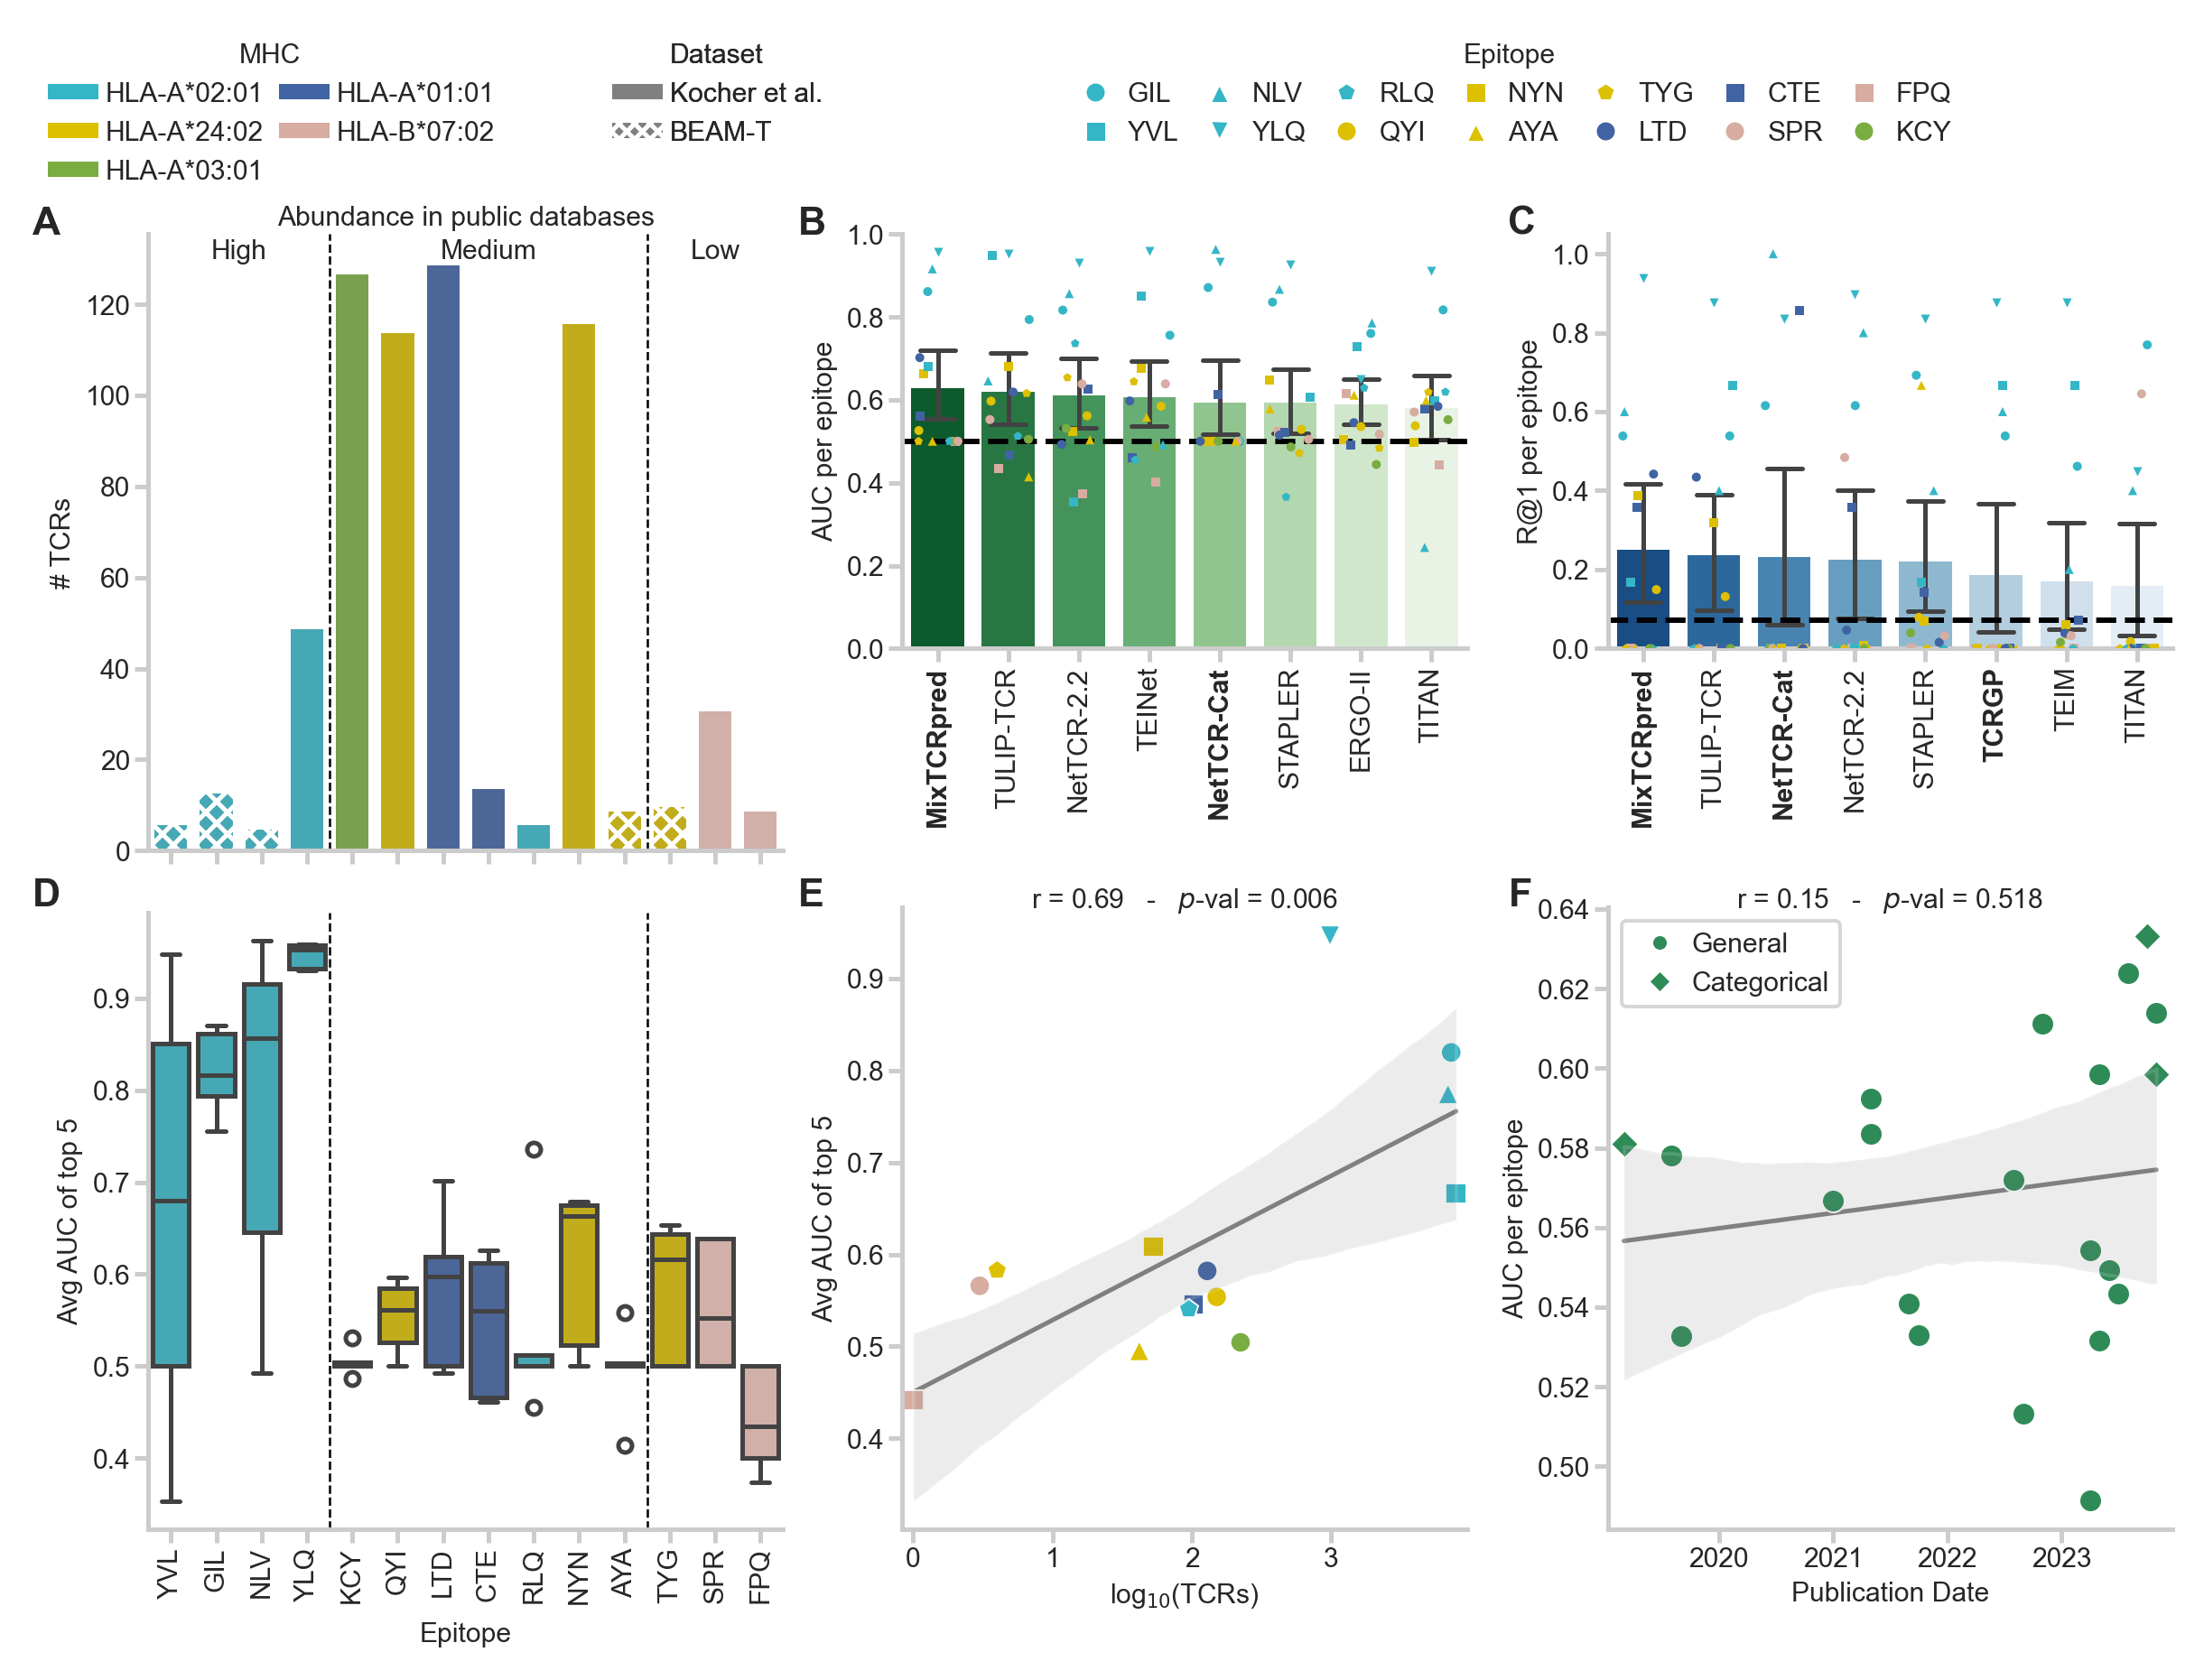

In [59]:
scale = 1
fig = plt.figure(figsize=(TEXT_WIDTH * scale, TEXT_WIDTH * scale * 0.75), #0.65
                 dpi=DPI)
set_font_size(6)
utils_plot.LINEWIDTH = 1

gridspecs = {}

gridspecs["full"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    height_ratios=[1,],
    width_ratios=[1, 2],
)

gridspecs["ad"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['full'][0],
    nrows=2,
    ncols=1,
    height_ratios=[1, 1.],
    width_ratios=[1, ],
    hspace=0.1
)

gridspecs["bcef"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['full'][1],
    nrows=2,
    ncols=1,
    height_ratios=[1, 1.5],
    width_ratios=[1, ],
    hspace=0.5
)


gridspecs["bc"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['bcef'][0],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    wspace=0.25
)

gridspecs["ef"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['bcef'][1],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    wspace=0.25
)


ax_a = fig.add_subplot(gridspecs["ad"][0])
ax_b = fig.add_subplot(gridspecs["bc"][0])
ax_c = fig.add_subplot(gridspecs["bc"][1])

ax_d = fig.add_subplot(gridspecs["ad"][1])
ax_e = fig.add_subplot(gridspecs["ef"][0])
ax_f = fig.add_subplot(gridspecs["ef"][1])


plot_epitopes(ax_a)
ax_a.set_xlabel(None)

plot_barplot(df_performance_best, 'AUC', n_top=8, cmap='Greens_r', ax=ax_b, rdm=0.5, 
             hue='Group', palette=epitope_mhc_colors, markers=markers_epitope)
ax_b.set_ylabel('AUC per epitope')
legend_handles = [plt.Line2D([0], [0], marker=markers_epitope[epi], color='w', 
                             markerfacecolor=epitope_mhc_colors[epi], markersize=5, label=epi[:3])
                  for epi in markers_epitope.keys()]
ax_b.legend(handles=legend_handles, ncols=7, frameon=False, title='Epitope',
            columnspacing=0.5, handletextpad=0.2,
            loc='upper left', bbox_to_anchor=(0.25, 1.52))
ax_b.set_ylim(0, 1)
labels = ax_b.get_xticklabels()
[el.set_weight('bold') for el in labels if el.get_text() in ['NetTCR-Cat', 'MixTCRpred', 'TCRGP']]


plot_barplot(df_performance_best, 'R@1', n_top=8, cmap='Blues_r', ax=ax_c, rdm=1/14, 
             hue='Group', palette=epitope_mhc_colors, markers=markers_epitope)
ax_c.set_ylabel('R@1 per epitope')
ax_c.legend().remove()
labels = ax_c.get_xticklabels()
[el.set_weight('bold') for el in labels if el.get_text() in ['NetTCR-Cat', 'MixTCRpred', 'TCRGP']]

plot_metric_by_epitope(df_performance_best, 'AUC', 5, ax=ax_d)
ax_d.set_ylabel('Avg AUC of top 5')
ax_d.set_xlabel('Epitope')

plot_dbs_vs_performance(df_performance_best, 'AUC', 5, ax=ax_e)
ax_e.set_ylabel('Avg AUC of top 5')

plot_property_vs_performance('Date', 'AUC', ax=None, size=25)
ax_f.set_xlabel('Publication Date')
ax_f.set_ylabel('AUC per epitope')

legend_handles = [
    Line2D([0], [0], marker='o', color='seagreen', label='General',
           markersize=2, linestyle='None'),
    Line2D([0], [0], marker='D', color='seagreen', label='Categorical',
           markersize=2, linestyle='None'),
]
ax_f.legend(handles=legend_handles, columnspacing=0.5, handletextpad=0.2,)

fig.text(0.005, 0.97, ' ', size='x-large', weight='bold', color='white')

fig.text(0.005, 0.88, 'A', size='x-large', weight='bold')
fig.text(0.355, 0.88, 'B', size='x-large', weight='bold')
fig.text(0.68, 0.88, 'C', size='x-large', weight='bold')

fig.text(0.005, 0.47, 'D', size='x-large', weight='bold')
fig.text(0.355, 0.47, 'E', size='x-large', weight='bold')
fig.text(0.68, 0.47, 'F', size='x-large', weight='bold')


fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.savefig('../figures/fig_viral_benchmark.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/fig_viral_benchmark.png',
           dpi=DPI, bbox_inches='tight')

## SFigure 1 - All Models

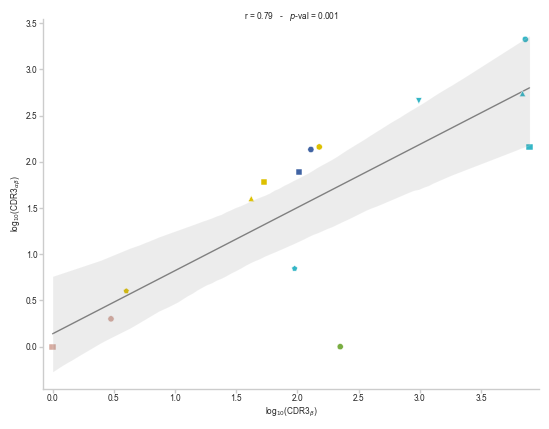

In [60]:
def plot_paired_vs_beta(ax=None):
    df_tmp = pd.concat([df_all_dbs, df_all_dbs_paired], axis=1)
    df_tmp.columns = ['CDR3b', 'CDR3ab']
    df_tmp['log(CDR3b)'] = np.log10(1 + df_tmp['CDR3b'])
    df_tmp['log(CDR3ab)'] = np.log10(1 + df_tmp['CDR3ab'])
    df_tmp['Epitope'] = df_tmp.index

    plot = sb.scatterplot(data=df_tmp, x='log(CDR3b)', y='log(CDR3ab)',
                          hue='Epitope', style='Epitope',
                          palette=epitope_mhc_colors, markers=markers_epitope,
                         s=20, color='seagreen', ax=ax)
    df_tmp = df_tmp.copy()
    plot = sb.regplot(data=df_tmp, x='log(CDR3b)', y='log(CDR3ab)',
                      color='gray', ax=ax, scatter=False, line_kws={'zorder': -1, 
                                                                    'linewidth': utils_plot.LINEWIDTH})
    delta = df_tmp['log(CDR3b)'].max() - df_tmp['log(CDR3b)'].min()
    plot.set_xlim(df_tmp['log(CDR3b)'].min()-0.02*delta, df_tmp['log(CDR3b)'].max()+0.02*delta,)
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.set_xlabel('log$_{10}$(CDR3$_{β}$)', labelpad=2)
    plot.set_ylabel('log$_{10}$(CDR3$_{αβ}$)', labelpad=2)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)
    plot.legend().remove()
    
    corr, p_val = pearsonr(df_tmp['log(CDR3b)'].values, df_tmp['log(CDR3ab)'].values)
    plot.set_title(f'r = {corr:.2f}   -   $p$-val = {p_val:.3f}', pad=0)
    
plot_paired_vs_beta()

D:\Projects\benchmark\manuscript\utils_plot.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
D:\Projects\benchmark\manuscript\utils_plot.py:26: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
D:\Projects\benchmark\manuscript\utils_plot.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(xlabels, rotation=90)
D:\Projects\benchmark\manuscript\utils_plot.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
D:\Proje

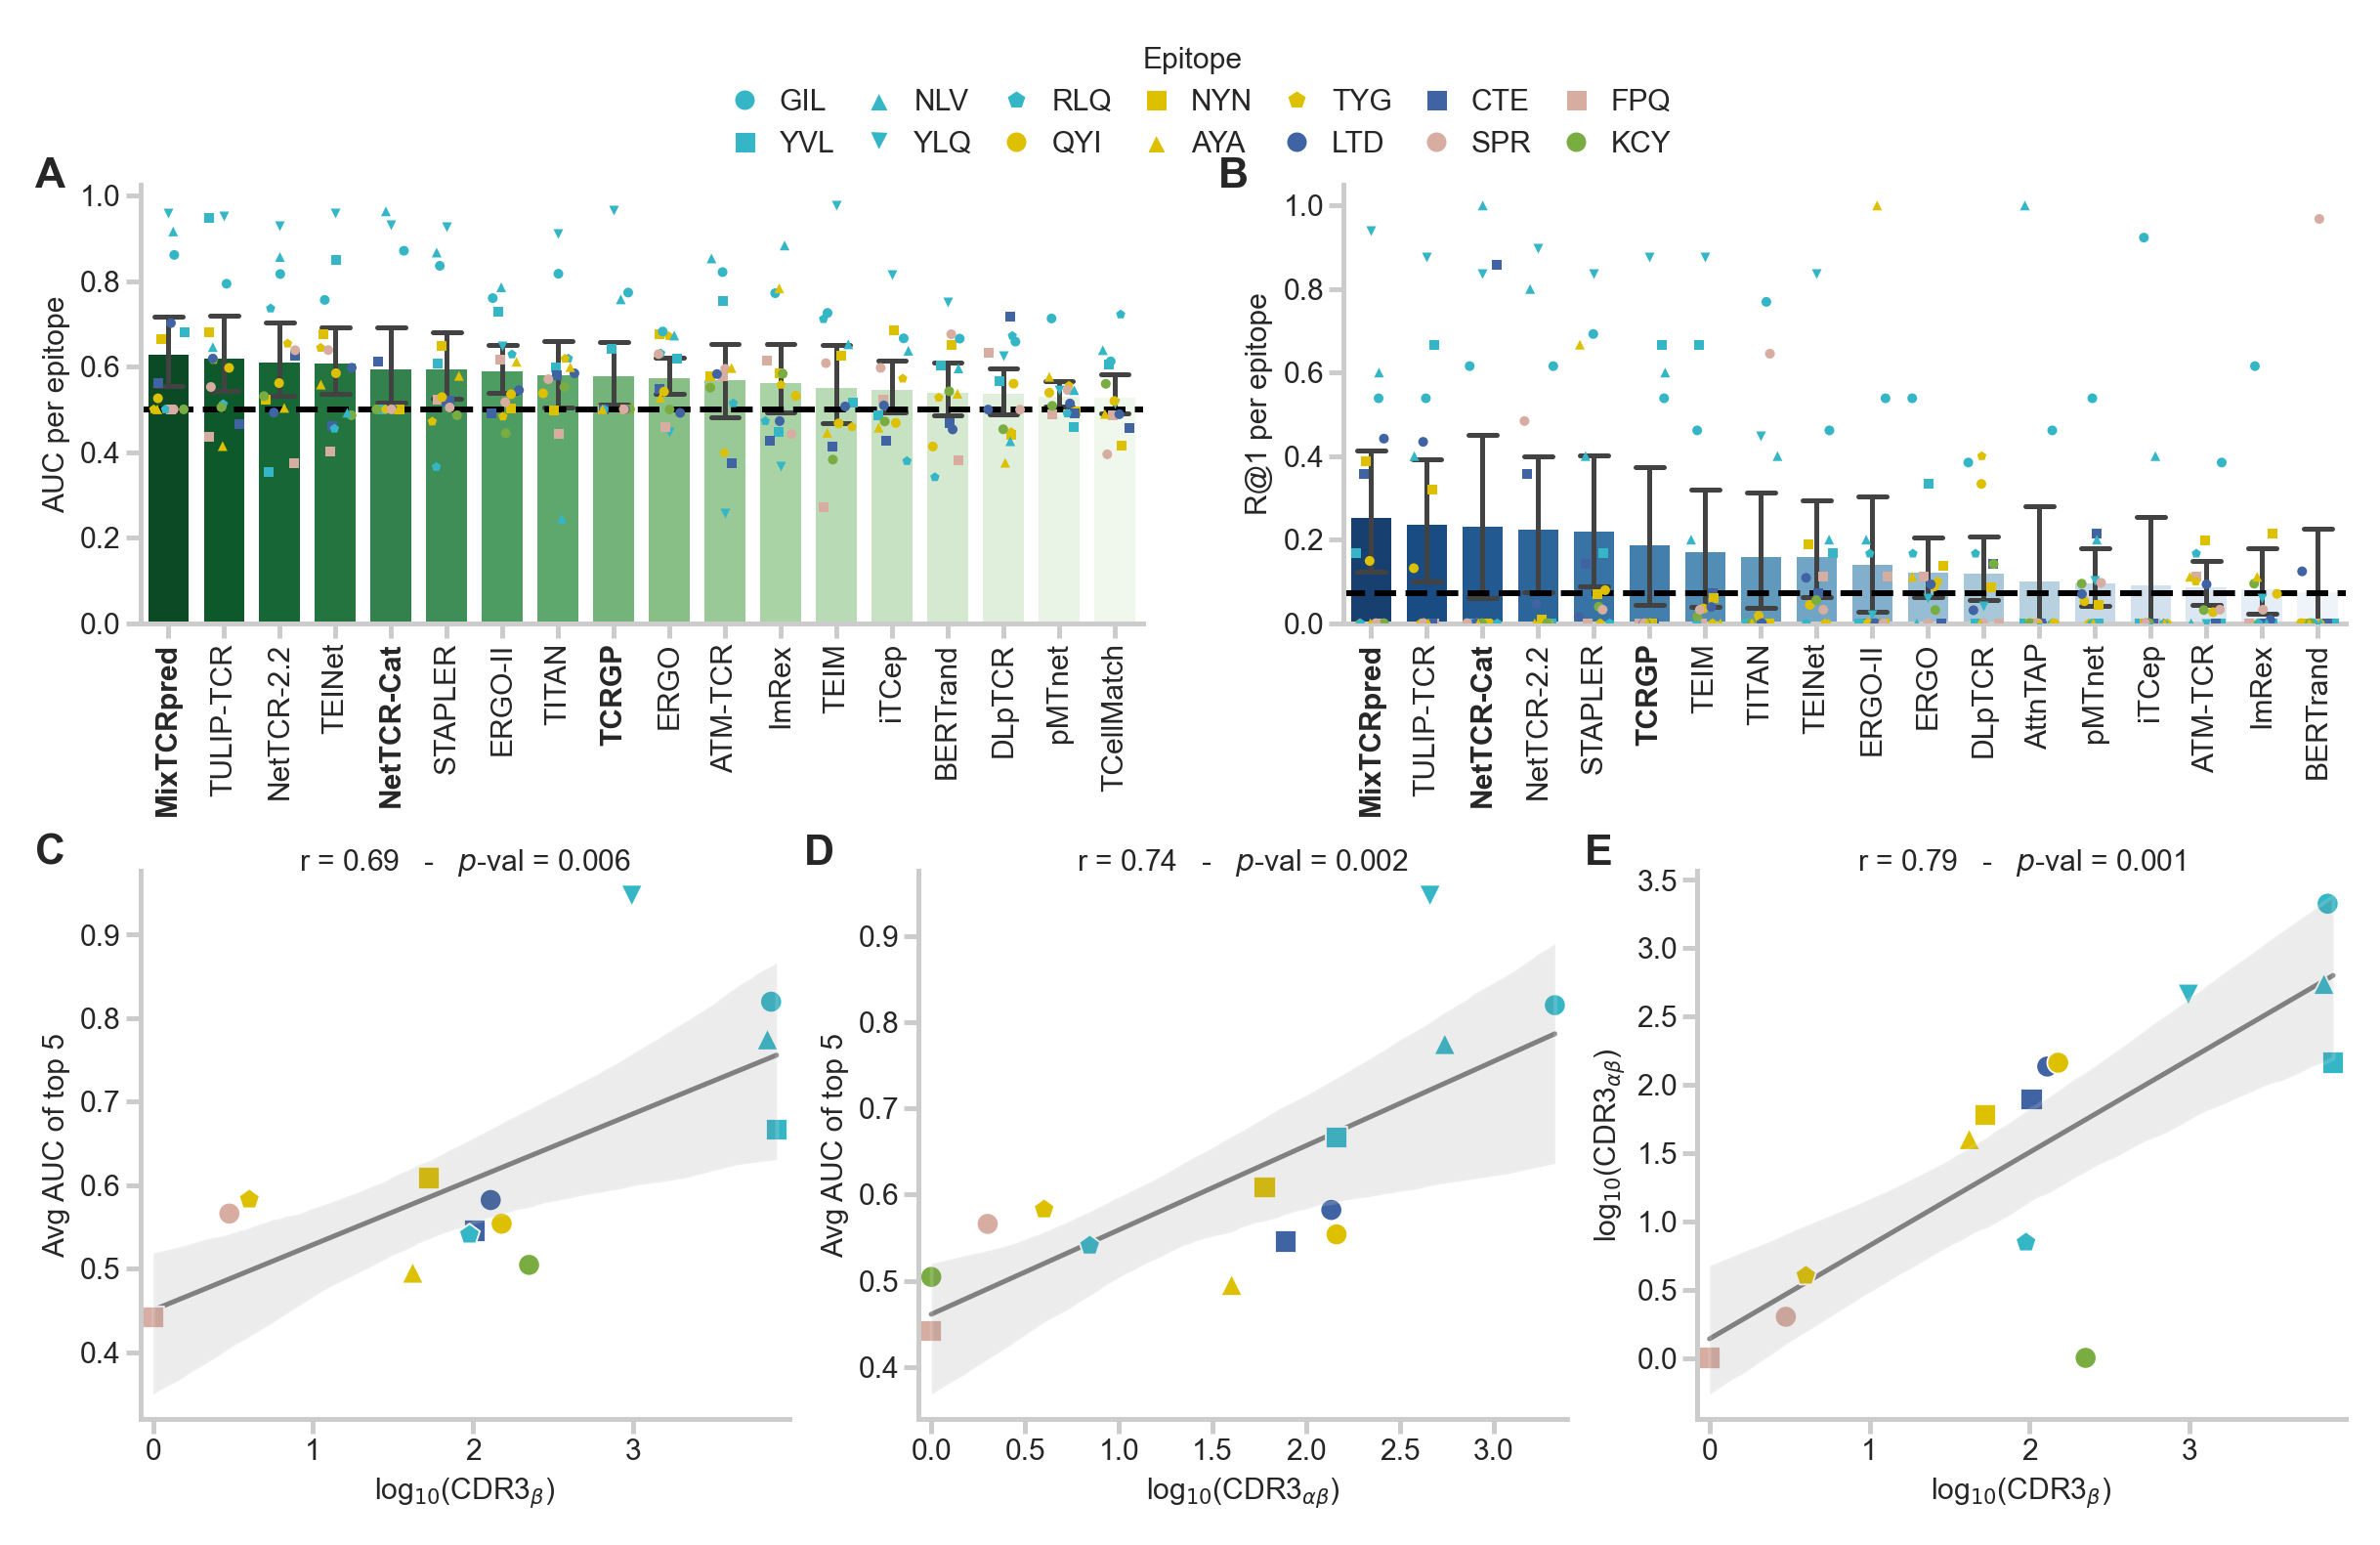

In [61]:
scale = 1
fig = plt.figure(figsize=(TEXT_WIDTH * scale, TEXT_WIDTH * scale * 0.65),
                 dpi=DPI)
set_font_size(6)
utils_plot.LINEWIDTH = 1

gridspecs = {}

gridspecs["full"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=1,
    height_ratios=[1, 1.25],
    width_ratios=[1],
)

gridspecs["ab"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['full'][0],
    nrows=1,
    ncols=2,
    height_ratios=[1,],
    width_ratios=[1, 1],
)
gridspecs["cde"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['full'][1],
    nrows=1,
    ncols=3,
    height_ratios=[1,],
    width_ratios=[1, 1, 1],
)

ax_a = fig.add_subplot(gridspecs["ab"][0])
ax_b = fig.add_subplot(gridspecs["ab"][1])
ax_c = fig.add_subplot(gridspecs["cde"][0])
ax_d = fig.add_subplot(gridspecs["cde"][1])
ax_e = fig.add_subplot(gridspecs["cde"][2])


plot_barplot(df_performance_best, 'AUC', n_top=18, cmap='Greens_r', ax=ax_a, rdm=0.5,
            hue='Group', palette=epitope_mhc_colors, markers=markers_epitope)
ax_a.set_ylabel('AUC per epitope')
ax_a.legend().remove()
labels = ax_a.get_xticklabels()
[el.set_weight('bold') for el in labels if el.get_text() in ['NetTCR-Cat', 'MixTCRpred', 'TCRGP']]

plot_barplot(df_performance_best, 'R@1', n_top=18, cmap='Blues_r', ax=ax_b, rdm=1/14,
            hue='Group', palette=epitope_mhc_colors, markers=markers_epitope)
ax_b.set_ylabel('R@1 per epitope')
ax_b.legend().remove()
labels = ax_b.get_xticklabels()
[el.set_weight('bold') for el in labels if el.get_text() in ['NetTCR-Cat', 'MixTCRpred', 'TCRGP']]

legend_handles = [plt.Line2D([0], [0], marker=markers_epitope[epi], color='w', 
                             markerfacecolor=epitope_mhc_colors[epi], markersize=5, label=epi[:3])
                  for epi in markers_epitope.keys()]
ax_b.legend(handles=legend_handles, ncols=7, frameon=False, title='Epitope',
            columnspacing=0.5, handletextpad=0.2,
            loc='lower center', bbox_to_anchor=(-0.15, 1.0))

plot_dbs_vs_performance(df_performance_best, 'AUC', 5, df_all_dbs, ax=ax_c)
ax_c.set_ylabel('Avg AUC of top 5')
ax_c.set_xlabel('log$_{10}$(CDR3$_{β}$)', labelpad=2)

plot_dbs_vs_performance(df_performance_best, 'AUC', 5, df_all_dbs_paired, ax=ax_d)
ax_d.set_ylabel('Avg AUC of top 5')
ax_d.set_xlabel('log$_{10}$(CDR3$_{αβ}$)', labelpad=2)


plot_paired_vs_beta(ax_e)

fig.text(0.01, 0.88, 'A', size='x-large', weight='bold')
fig.text(0.51, 0.88, 'B', size='x-large', weight='bold')
fig.text(0.01, 0.44, 'C', size='x-large', weight='bold')
fig.text(0.335, 0.44, 'D', size='x-large', weight='bold')
fig.text(0.665, 0.44, 'E', size='x-large', weight='bold')

fig.tight_layout()
fig.savefig('../figures/sfig_viral_benchmark_all.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/sfig_viral_benchmark_all.png',
           dpi=DPI, bbox_inches='tight')

## SFigure 2 - Model Alternatives

In [62]:
base_methods = sorted(df_performance_alt['BaseModel'].unique(), key=lambda x: x.lower())
colors_models = {m: met_brewer.met_brew(name='Signac', n=10, brew_type='discrete')[i]  # sb.color_palette('pastel')[i] 
                 for i, m in enumerate(base_methods)}

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\550410981.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\550410981.py:12: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\550410981.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(xlabels, rotation=90, fontsize='x-small')


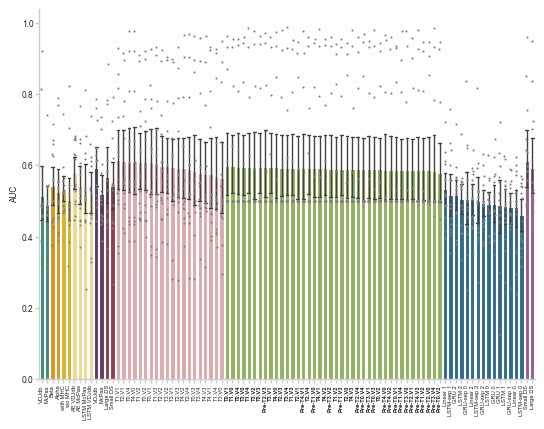

In [63]:
def plot_alternatives(df, metric, sort_by='Average', ax=None, rdm=None):
    df_plot = df[(df['Metric']==metric) & (~df['Group'].isin(['full_data', 'Average', 'WeightedAverage']))].copy()
    mean_perf = df_plot.groupby('Method')['Value'].mean().to_dict()
    df_plot['avgValue'] = df_plot['Method'].map(mean_perf)
    
    order = df[(df['Metric']=='AUC') & (df['Group']==sort_by)].sort_values(['BaseModel', 'Value'], ascending=[True, False],
                                                                           )['Method'].values
    
    order_base = df[(df['Metric']=='AUC') & (df['Group']==sort_by)].sort_values(['Method'])['BaseModel'].values
    palette = [colors_models[m] for m in order_base]

    plot = sb.barplot(data=df_plot, y='Value', x='Method',
                          order=order,
                          palette=palette,
                          errwidth=utils_plot.LINEWIDTH,
                          capsize=0.5,
                          ax=ax)
    plot = sb.stripplot(data=df_plot, y='Value', x='Method',
                          order=order,
                          color='gray',
                          size=1.5,
                          ax=ax)

    xlabels = plot.get_xticklabels()
    [el.set_weight('bold') for el in xlabels if el.get_text().split(' ')[0] in ['nettcrcat', 'mixtcrpred', 'tcrgp']]
    [el.set_text(' '.join(el.get_text().split(' ')[1:])) for el in xlabels]
    plot.set_xticklabels(xlabels, rotation=90, fontsize='x-small')
    #labels = ax_b.get_xticklabels()
    #[el.set_weight('bold') for el in labels if el.get_text() in ['NetTCR-Cat', 'MixTCRpred', 'TCRGP']]

    sb.despine(ax=plot)
    plot.grid(False)
    plot.set_ylabel(metric, labelpad=2)
    plot.set_xlabel(None)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)

    plot.spines['left'].set_linewidth(utils_plot.LINEWIDTH)
    plot.spines['bottom'].set_linewidth(utils_plot.LINEWIDTH)

    if rdm is not None:
        plot.axhline(y=rdm, color='gray', linestyle='--')

plot_alternatives(df_performance_alt, 'AUC')

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\550410981.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\550410981.py:12: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  plot = sb.barplot(data=df_plot, y='Value', x='Method',
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\550410981.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(xlabels, rotation=90, fontsize='x-small')
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\550410981.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and se

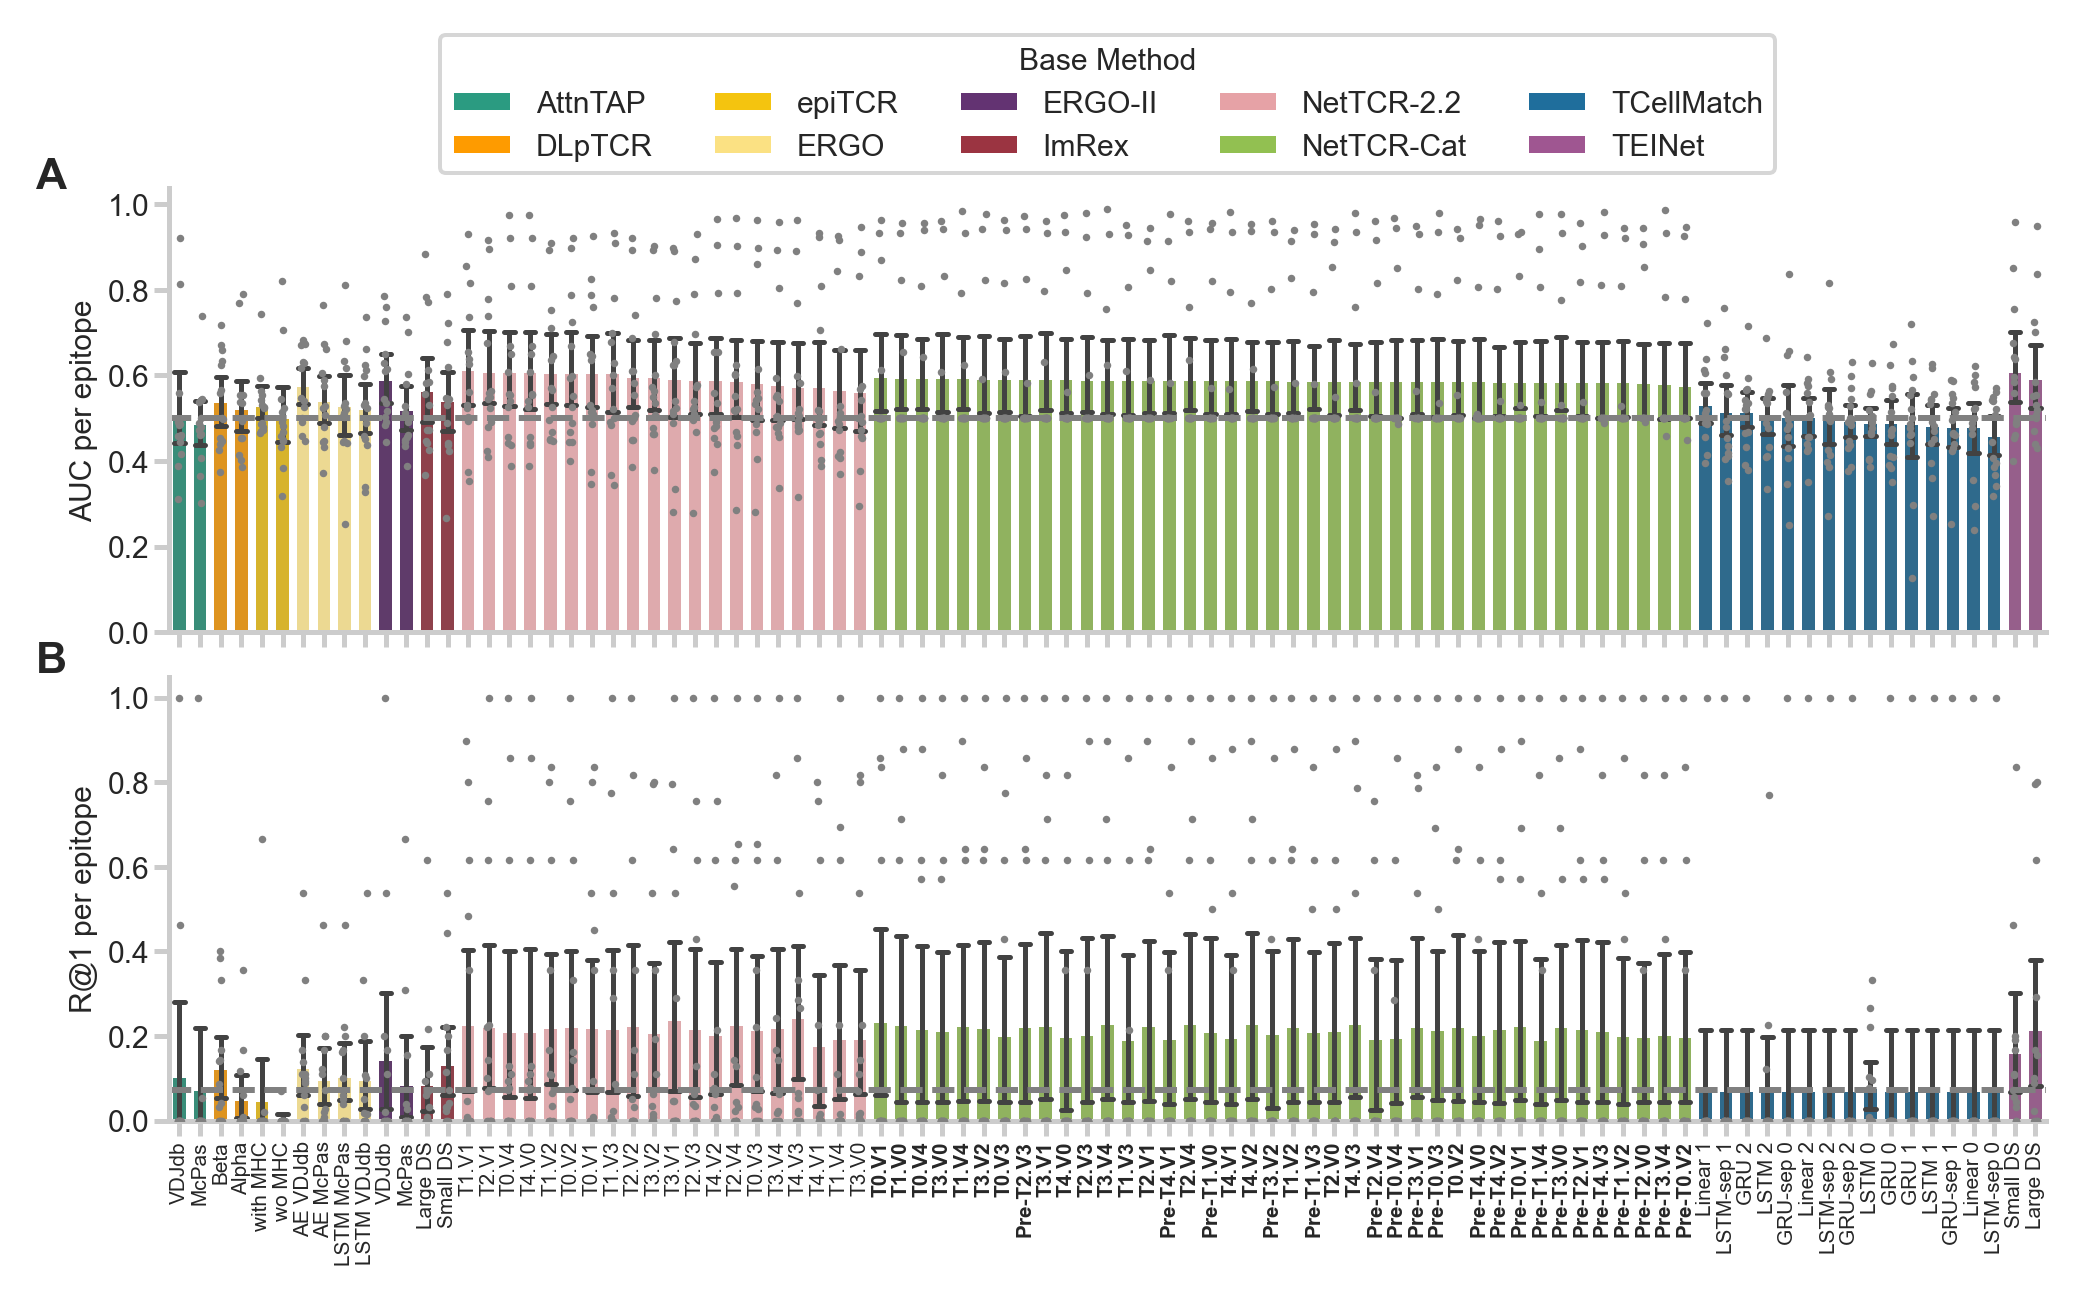

In [64]:
scale = 1
fig = plt.figure(figsize=(TEXT_WIDTH * scale, TEXT_WIDTH * scale * 0.5),
                 dpi=DPI)
set_font_size(6)
utils_plot.LINEWIDTH = 1

gridspecs = {}

gridspecs["full"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=1,
    height_ratios=[1, 1],
    width_ratios=[1],
    hspace=0.1
)


for i, metric in enumerate(['AUC', 'R@1']):    
    ax_ = fig.add_subplot(gridspecs["full"][i])
    plot_alternatives(df_performance_alt, metric, sort_by='Average', ax=ax_, rdm=0.5 if i==0 else 1/14)
    ax_.set_ylabel(f'{metric} per epitope')
    
    if i == 0:
        ax_.set_xticklabels([])
        custom_legend = [Patch(facecolor=c, label=utils_config.mapper_methods[l]) for l, c in colors_models.items()]
        ax_.legend(handles=custom_legend, title='Base Method', ncol=5, bbox_to_anchor=(0.5, 1), loc='lower center')

fig.text(0.07, 0.88, 'A', size='x-large', weight='bold')
fig.text(0.07, 0.48, 'B', size='x-large', weight='bold')

fig.tight_layout()
fig.savefig('../figures/sfig_viral_alternatives.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/sfig_viral_alternatives.png',
           dpi=DPI, bbox_inches='tight')

## SFigure X - Positive vs Negative Scores

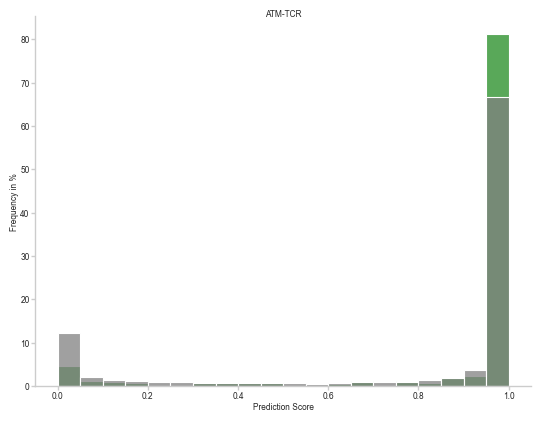

In [65]:
def plot_distribution(name, ax=None):
    n_bins = 20
    plot = sb.histplot(prediction_scores[prediction_scores['Label']==1], x=name, 
                      fill=True, color='forestgreen', label='Binding', stat='percent',
                      bins=n_bins,
                      common_norm=True, ax=ax)
    plot = sb.histplot(prediction_scores[prediction_scores['Label']==0], x=name, 
                      fill=True, color='gray', label='Non-binding', stat='percent',
                       bins=n_bins,
                      common_norm=True, ax=plot)
    
    plot.set_ylabel('Frequency in %', labelpad=1)
    plot.set_xlabel('Prediction Score', labelpad=1)
    plot.set_title(utils_config.mapper_methods[name.split('_')[0]], pad=0, 
                   weight='bold' if name.split('_')[0] in ['mixtcrpred', 'tcrgp', 'nettcrcat'] else None)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)
    
    sb.despine(ax=plot)
    plot.grid(False)
    
plot_distribution('atm-tcr')

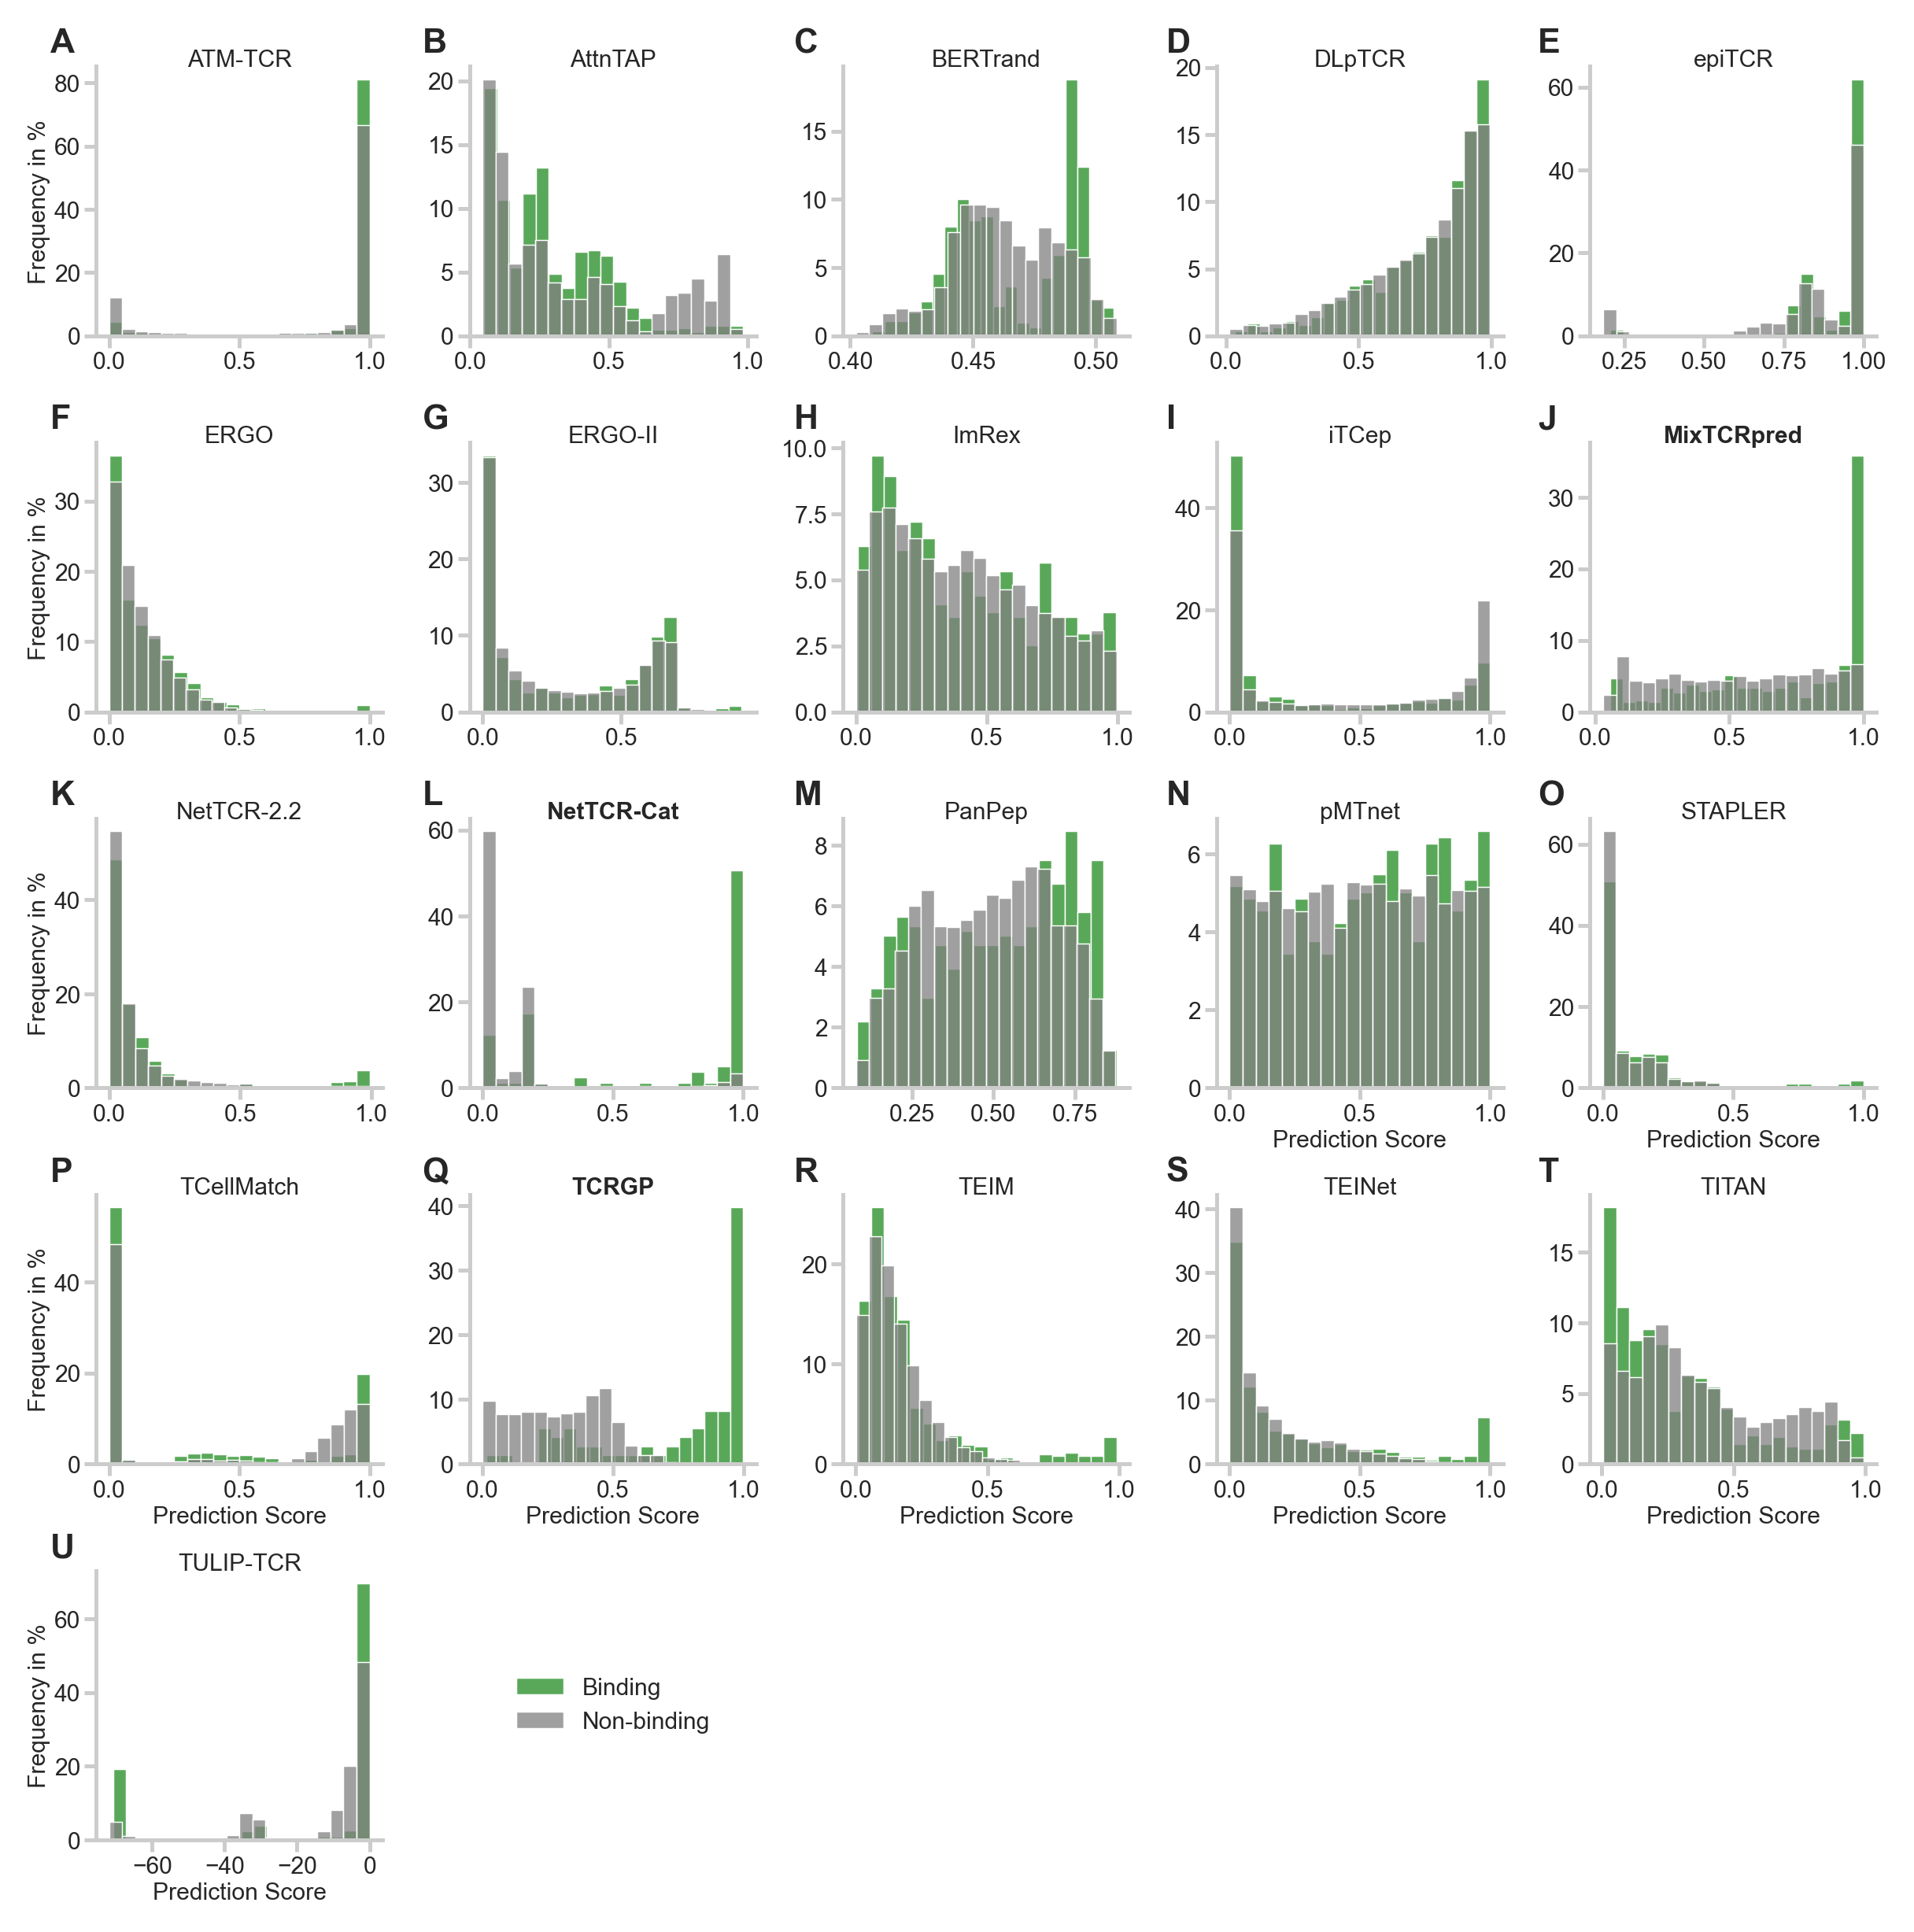

In [66]:
scale = 1
fig = plt.figure(figsize=(TEXT_WIDTH * scale, TEXT_WIDTH * scale * 1),
                 dpi=DPI)
set_font_size(6)
utils_plot.LINEWIDTH = 1

gridspecs = {}

gridspecs["full"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=5,
    ncols=5,
    height_ratios=[1, 1, 1, 1, 1],
    width_ratios=[1, 1, 1, 1, 1],
)


letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
for i, tag in enumerate(model_names_score):
    ax_tmp = fig.add_subplot(gridspecs["full"][i])
    plot_distribution(tag, ax_tmp)
    
    if i%5 != 0:
        ax_tmp.set_ylabel(None)
    if i < 13:
        ax_tmp.set_xlabel(None)
    
    fig.text(1/5.125*(i%5)+0.025, 0.985-i//5*0.1975, letters[i], size='x-large', weight='bold')
    

handles, labels = ax_tmp.get_legend_handles_labels()
ax_tmp = fig.add_subplot(gridspecs["full"][i+1])
ax_tmp.axis('off')
ax_tmp.legend(handles=handles, labels=labels, loc='center', bbox_to_anchor=(0.5, 0.5), frameon=False)

fig.tight_layout()
fig.savefig('../figures/sfig_viral_benchmark_distributions.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/sfig_viral_benchmark_distributions.png',
           dpi=DPI, bbox_inches='tight')

## SFigure X - Rank Distribution => Majority Class?

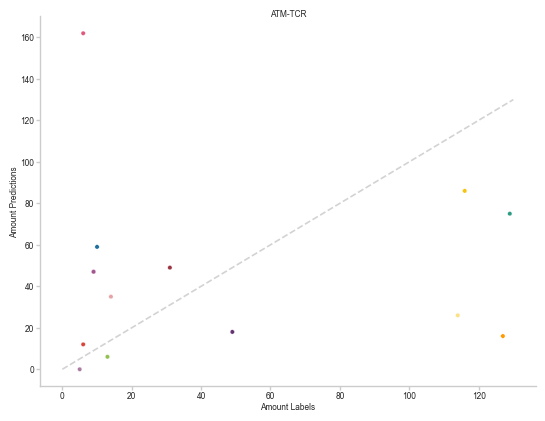

In [67]:
def plot_prediction_class(name, ax=None):
    df_counts = prediction_scores.sort_values(['clone_id', name], ascending=False)
    df_counts = df_counts.drop_duplicates(['clone_id', 'CDR3_alpha', 'CDR3_beta'], keep='first')['Epitope'].value_counts()
    df_counts = pd.DataFrame(df_counts)
    df_counts.columns = ['Amount Predictions']

    df_epis = pd.DataFrame(prediction_scores[prediction_scores['Label']==1]['Epitope'].value_counts())
    df_epis.columns = ['Amount Labels']
    df_counts = pd.concat([df_counts, df_epis], axis=1).fillna(0.0)
    df_counts['Epitope'] = df_counts.index
    df_counts = df_counts.sort_values('Amount Labels')
    
    plot = sb.scatterplot(data=df_counts, x='Amount Labels', y='Amount Predictions', hue='Epitope', 
                          palette=palette_epitopes, ax=ax, s=10)
    plot.plot([0, df_counts['Amount Labels'].max()+1], [0, df_counts['Amount Labels'].max()+1], 
              color='lightgrey', ls='--', zorder=-1)
    
    plot.set_ylabel('Amount Predictions', labelpad=1)
    plot.set_xlabel('Amount Labels', labelpad=1)
    plot.set_title(utils_config.mapper_methods[name.split('_')[0]], pad=0)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.legend().remove()
    
plot_prediction_class('atm-tcr', None)

scale = 1
fig = plt.figure(figsize=(TEXT_WIDTH * scale, TEXT_WIDTH * scale * 0.8),
                 dpi=DPI)
set_font_size(6)
utils_plot.LINEWIDTH = 1

gridspecs = {}

gridspecs["full"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=4,
    ncols=5,
    height_ratios=[1, 1, 1, 1],
    width_ratios=[1, 1, 1, 1, 1],
)


letters = 'abcdefghijklmnopqrstuvwxyz'
for i, tag in enumerate(model_names_score):
    ax_tmp = fig.add_subplot(gridspecs["full"][i])
    plot_prediction_class(tag, ax_tmp)
    
    if i%5 != 0:
        ax_tmp.set_ylabel(None)
    if i < 13:
        ax_tmp.set_xlabel(None)
    
    fig.text(1/5.125*(i%5)+0.025, 0.99-i//5*0.2425, letters[i], size='x-large', weight='bold')
    

handles, labels = ax_tmp.get_legend_handles_labels()
ax_tmp = fig.add_subplot(gridspecs["full"][i+1])
ax_tmp.axis('off')
ax_tmp.legend(handles=handles[:7], labels=labels[:7], loc='center right', bbox_to_anchor=(1.1, 0.5), frameon=False)

ax_tmp = fig.add_subplot(gridspecs["full"][i+2])
ax_tmp.axis('off')
ax_tmp.legend(handles=handles[-7:], labels=labels[-7:], loc='center left', bbox_to_anchor=(-0.1, 0.5), frameon=False)

fig.tight_layout()
fig.savefig('../figures/sfig_viral_benchmark_predictionClass.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/sfig_viral_benchmark_predictionClass.png',
           dpi=DPI, bbox_inches='tight')

### Average prediction score

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\1445680598.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


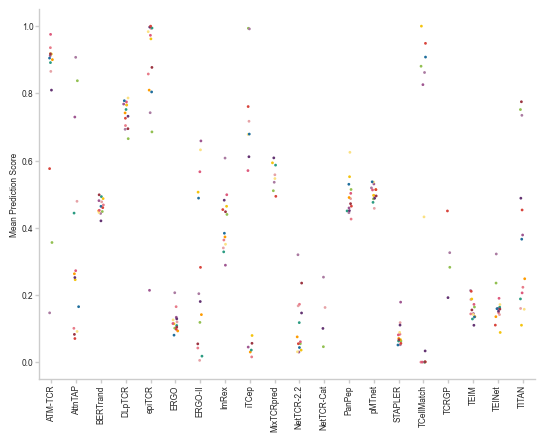

In [68]:
def plot_stats_prediction(stat, exclude=None, ax=None):
    df_tmp = prediction_scores[['Epitope'] + prediction_scores.columns.tolist()[-21:]]
    df_tmp = pd.melt(df_tmp, id_vars=['Epitope'], var_name='Method', value_name='Value')
    
    if stat.lower() == 'std':
        df_tmp = df_tmp.groupby(['Method', 'Epitope']).std()
    else:
        df_tmp = df_tmp.groupby(['Method', 'Epitope']).mean()
    df_tmp = df_tmp.reset_index()
    df_tmp['Dataset'] = df_tmp['Epitope'].apply(lambda x: 'Tumor' if x.startswith('R') else 'CMV')
    
    if exclude is not None:
        df_tmp = df_tmp[~df_tmp['Method'].isin(exclude)]
    df_tmp['Method'] = df_tmp['Method'].str.split('_').str[0]
    df_tmp['Method'] = df_tmp['Method'].map(utils_config.mapper_methods)
    
    plot = sb.stripplot(data=df_tmp, x='Method', y='Value',
                          hue='Epitope', palette=palette_epitopes,
                         size=2, ax=ax)
    
    sb.despine(ax=plot)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
    plot.grid(False)
    plot.set_ylabel(f'{stat} Prediction Score', labelpad=2)
    plot.set_xlabel(None)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)
    plot.legend().remove()

plot_stats_prediction('Mean', ['tulip-tcr'])

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\2495406402.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


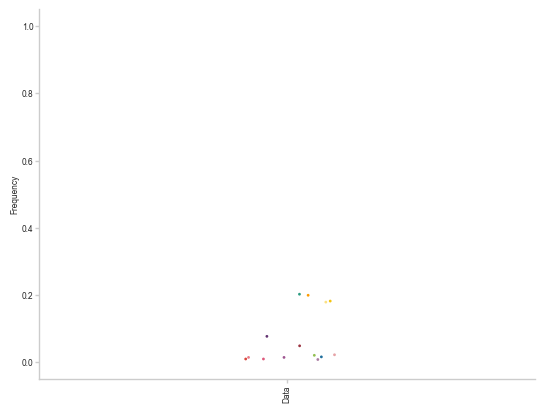

In [69]:
def plot_stats_data(stat, ax=None):
    df_tmp = prediction_scores[['Epitope', 'Label']]
    df_tmp = df_tmp.groupby('Epitope')['Label']
    if stat.lower() == 'std':
        df_tmp = df_tmp.std()
    else:
        df_tmp = df_tmp.mean()
    df_tmp = df_tmp.reset_index()
    df_tmp['Method'] = 'Data'

    plot = sb.stripplot(data=df_tmp, x='Method', y='Label',
                          hue='Epitope', palette=palette_epitopes,
                         size=2, ax=ax)
    
    sb.despine(ax=plot)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
    plot.grid(False)
    if stat.lower() == 'mean':
        plot.set_ylabel(f'Frequency', labelpad=2)
    else:
        plot.set_ylabel(f'Std', labelpad=2)
    plot.set_xlabel(None)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)
    plot.legend().remove()
    plot.set_ylim(-0.05, 1.05)

plot_stats_data('Mean')

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\2495406402.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\1445680598.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\1445680598.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\2495406402.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\1445680598.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabe

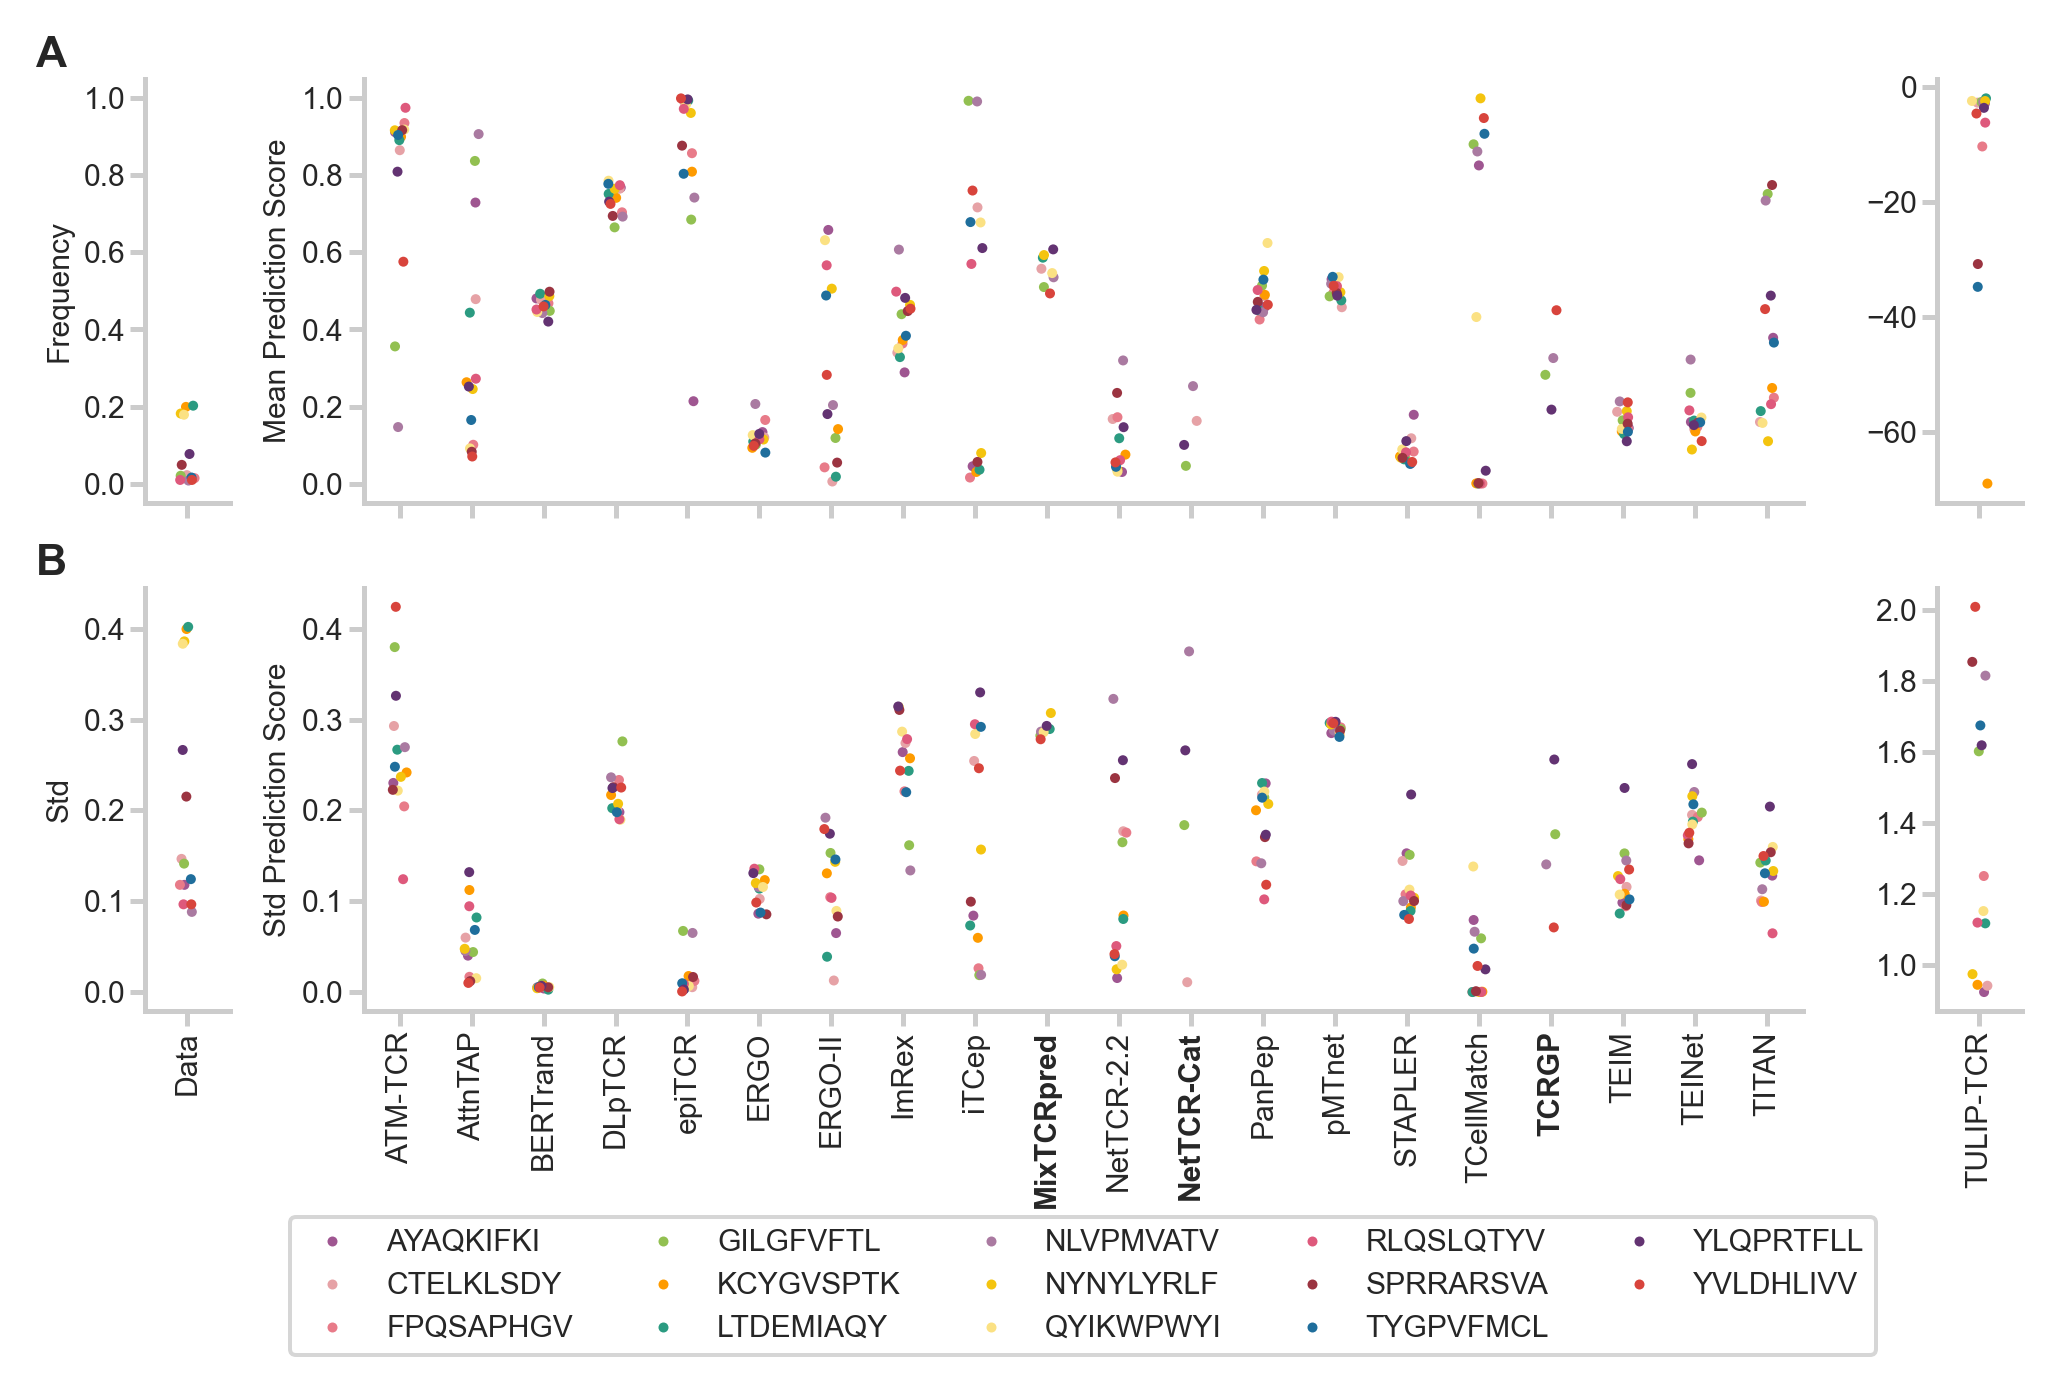

In [70]:
scale = 1
fig = plt.figure(figsize=(TEXT_WIDTH * scale, TEXT_WIDTH * scale * 0.5),
                 dpi=DPI)
set_font_size(6)
utils_plot.LINEWIDTH = 1

gridspecs = {}

gridspecs["full"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=3,
    height_ratios=[1, 1,],
    width_ratios=[1, 17, 1],
    wspace=0.25
)

ax_a1 = fig.add_subplot(gridspecs["full"][0])
ax_a2 = fig.add_subplot(gridspecs["full"][1])
ax_a3 = fig.add_subplot(gridspecs["full"][2])
ax_b1 = fig.add_subplot(gridspecs["full"][3])
ax_b2 = fig.add_subplot(gridspecs["full"][4])
ax_b3 = fig.add_subplot(gridspecs["full"][5])
    
plot_stats_data('Mean', ax_a1)
plot_stats_prediction('Mean', ['tulip-tcr'], ax_a2)
plot_stats_prediction('Mean', [el for el in best_models if el != 'tulip-tcr'] + best_models_cat, ax_a3)


plot_stats_data('Std', ax_b1)
plot_stats_prediction('Std', ['tulip-tcr'], ax_b2)
plot_stats_prediction('Std', [el for el in best_models if el != 'tulip-tcr'] + best_models_cat, ax_b3)

ax_a1.set_xticklabels([])
ax_a2.set_xticklabels([])
ax_a3.set_xticklabels([])

ax_a3.set_ylabel(None)
ax_b3.set_ylabel(None)

xlabels = ax_b2.get_xticklabels()
[el.set_weight('bold') for el in xlabels if el.get_text() in ['NetTCR-Cat', 'MixTCRpred', 'TCRGP']]
ax_b2.legend(ncols=5, loc='upper center', bbox_to_anchor=(0.5, -0.45), frameon=True)

ax_a1.set_ylim(ax_a2.get_ylim())
ax_b1.set_ylim(ax_b2.get_ylim())
    
fig.text(0.08, 0.89, 'A', size='x-large', weight='bold')
fig.text(0.08, 0.47, 'B', size='x-large', weight='bold')


fig.tight_layout()
fig.savefig('../figures/sfig_viral_predictionScores.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/sfig_viral_predictionScores.png',
           dpi=DPI, bbox_inches='tight')

## Mean Performance vs on full data

In [71]:
colors_models = met_brewer.met_brew(name="Redon", n=18, brew_type="continuous")

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\1794083857.py:19: UserWarning: 
The palette list has fewer values (18) than needed (21) and will cycle, which may produce an uninterpretable plot.
  plot = sb.scatterplot(data=df_tmp, x='averaged', y='full_data',


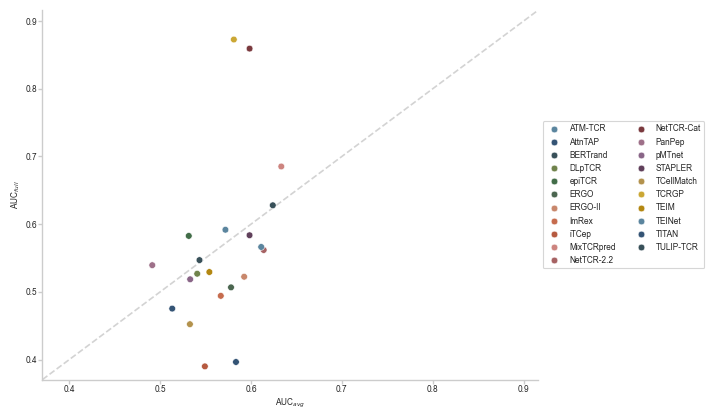

In [72]:
def plot_mean_vs_full(metric, ax=None, weighted=False):
    df_tmp = df_performance_best[(df_performance_best['Metric']==metric)
                                & (~df_performance_best['Group'].isin(['Average', 'WeightedAverage']))].copy()
    df_full = df_tmp[df_tmp['Group']=='full_data'][['BaseModel', 'Value']].set_index('BaseModel').copy()
    df_avg = df_tmp[df_tmp['Group']!='full_data'].copy()
    if weighted:
        df_avg['support'] = df_avg['Group'].map(amount_epis) / sum(amount_epis.values)
        df_avg['Value'] = df_avg['Value'] * df_avg['support'] 
        df_avg = pd.DataFrame(df_avg.groupby('BaseModel')['Value'].sum())
    else:
        df_avg = pd.DataFrame(df_avg.groupby('BaseModel')['Value'].mean())
    
    df_tmp = pd.concat([df_full, df_avg], axis=1)
    df_tmp.columns = ['full_data', 'averaged']
    df_tmp = df_tmp.reset_index()
    df_tmp = df_tmp.sort_values('BaseModel')
    df_tmp['BaseModel'] = df_tmp['BaseModel'].map(utils_config.mapper_methods)
    
    plot = sb.scatterplot(data=df_tmp, x='averaged', y='full_data', 
                          hue='BaseModel', palette=colors_models, ax=ax)
    
    max_ = df_tmp[['full_data', 'averaged']].max().max() * 1.05
    min_ = df_tmp[['full_data', 'averaged']].min().min() * 0.95
    plot.set_xlim((min_, max_))
    plot.set_ylim((min_, max_))
    
    plot.plot([min_, max_], [min_, max_], color='lightgrey', ls='--', zorder=-1)
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.set_xlabel('AUC$_{avg}$', labelpad=2)
    plot.set_ylabel('AUC$_{full}$', labelpad=2)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)
    plot.legend(ncols=2, loc='center left', bbox_to_anchor=(1, 0.5), )
    
plot_mean_vs_full('AUC')

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\1343759257.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


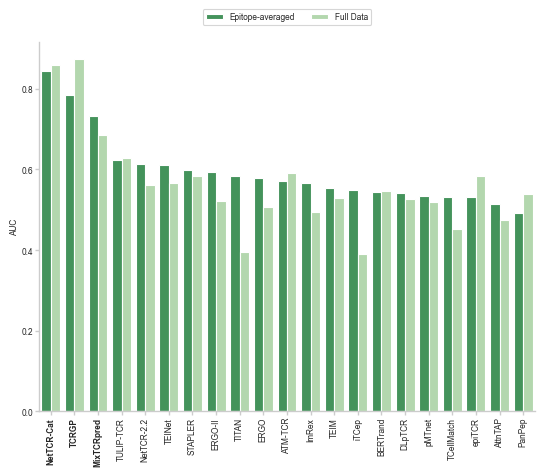

In [73]:
def plot_mean_vs_full_bar(metric, ax=None, weighted=False):
    df_tmp = df_performance_best[(df_performance_best['Metric']==metric)
                                & (~df_performance_best['Group'].isin(['Average', 'WeightedAverage']))].copy()
    df_full = df_tmp[df_tmp['Group']=='full_data'][['BaseModel', 'Value']].set_index('BaseModel').copy()
    df_avg = df_tmp[df_tmp['Group']!='full_data'].copy()
    if weighted:
        df_avg['support'] = df_avg['Group'].map(amount_epis) / sum(amount_epis.values)
        df_avg['Value'] = df_avg['Value'] * df_avg['support'] 
        df_avg = pd.DataFrame(df_avg.groupby('BaseModel')['Value'].sum())
    else:
        df_avg = df_avg[~df_avg['BaseModel'].isin(['mixtcrpred', 'tcrgp', 'nettcrcat']) | (df_avg['Value']!=0.5)]
        df_avg = pd.DataFrame(df_avg.groupby('BaseModel')['Value'].mean())
    
    df_avg['Type'] = 'Epitope-averaged'
    df_full['Type'] = 'Full Data'
    df_tmp = pd.concat([df_full, df_avg], axis=0)
    df_tmp = df_tmp.reset_index()
    df_tmp['BaseModel'] = df_tmp['BaseModel'].map(utils_config.mapper_methods)
    order = df_tmp[df_tmp['Type']=='Epitope-averaged'].sort_values('Value', ascending=False)['BaseModel'].values
    df_tmp['BaseModel'] = pd.Categorical(df_tmp['BaseModel'], categories=order, ordered=True)
    df_tmp = df_tmp.sort_values('BaseModel')
    
    plot = sb.barplot(data=df_tmp, x='BaseModel', y='Value', hue='Type',
                      palette='Greens_r', hue_order=['Epitope-averaged', 'Full Data'], ax=ax)
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.set_xlabel(None)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
    plot.set_ylabel('AUC', labelpad=2)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)
    plot.legend(ncols=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    
    labels = plot.get_xticklabels()
    [el.set_weight('bold') for el in labels if el.get_text() in ['NetTCR-Cat', 'MixTCRpred', 'TCRGP']]
    
plot_mean_vs_full_bar('AUC')

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\1343759257.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


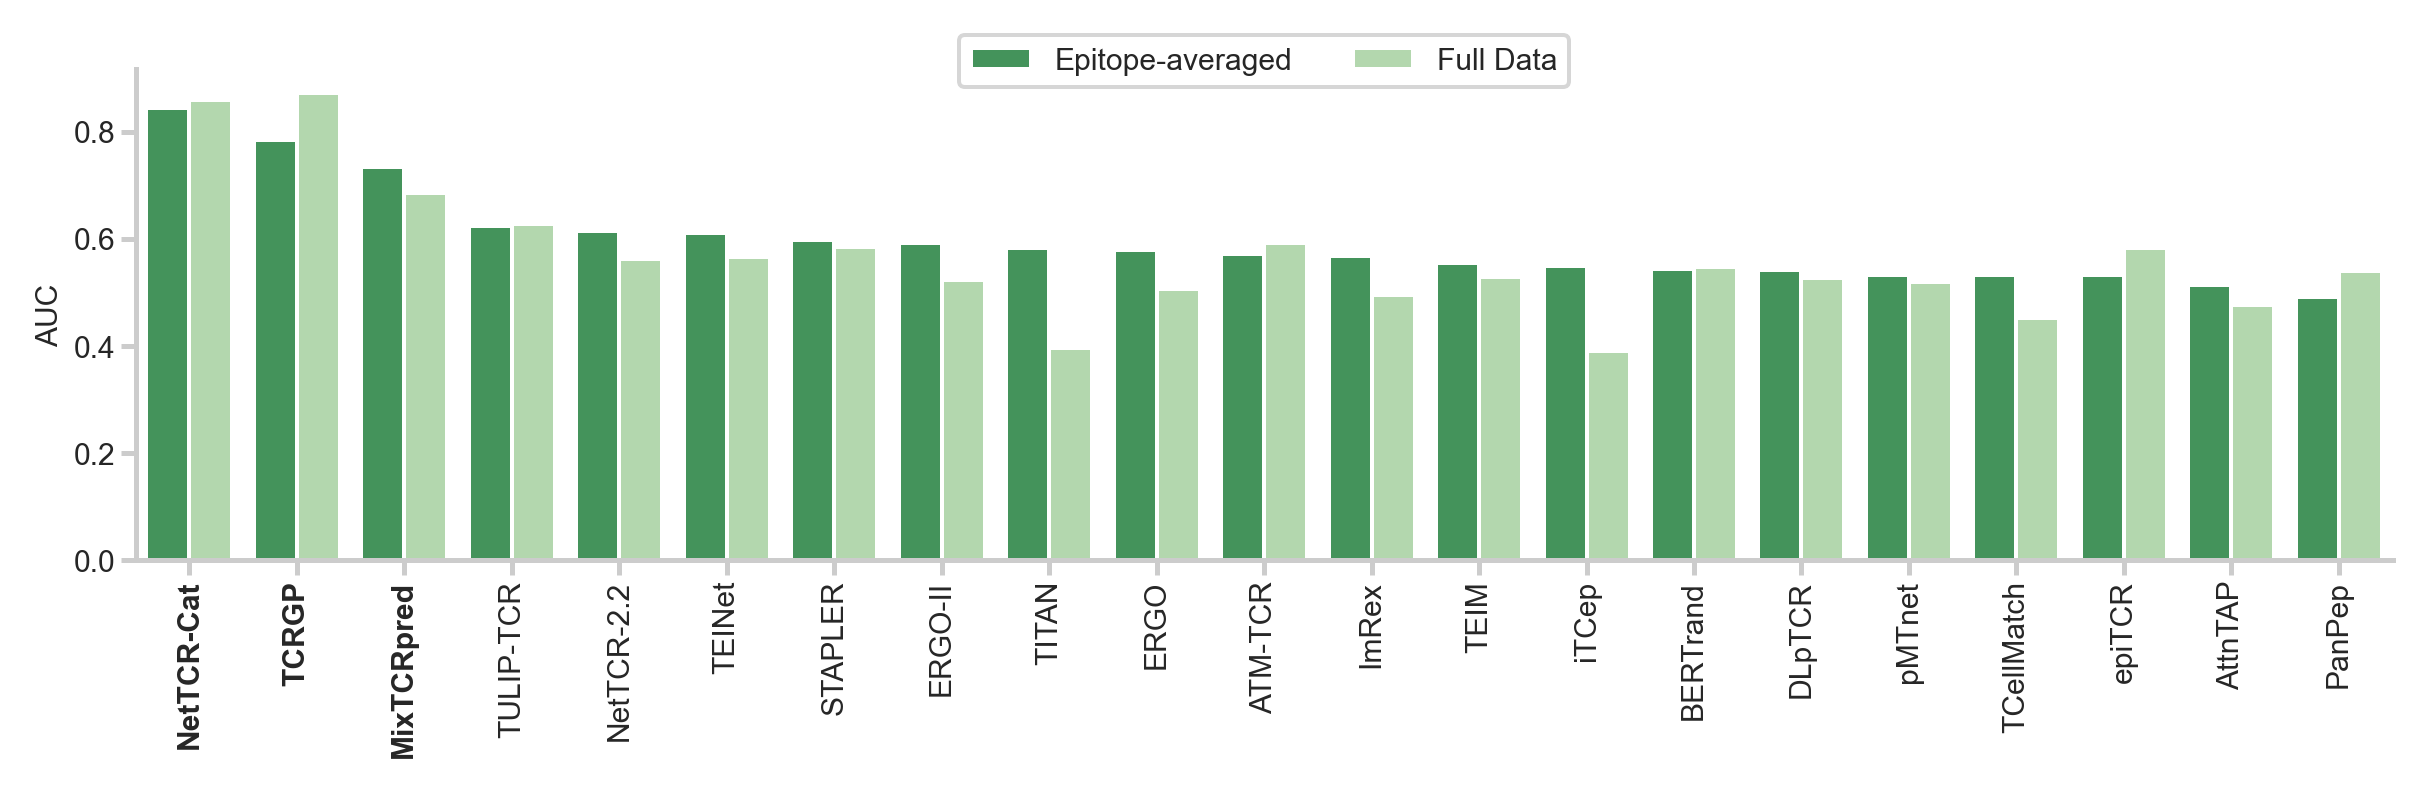

In [74]:
scale = 1
fig = plt.figure(figsize=(TEXT_WIDTH * scale, TEXT_WIDTH * scale * 0.33),
                 dpi=DPI)
set_font_size(6)
utils_plot.LINEWIDTH = 1

gridspecs = {}

gridspecs["full"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=1,
    height_ratios=[1],
    width_ratios=[1],
)

ax_a = fig.add_subplot(gridspecs["full"][0])

plot_mean_vs_full_bar('AUC', ax_a)

fig.tight_layout()
fig.savefig('../figures/sfig_viral_avg_vs_full.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/sfig_viral_avg_vs_full.png',
           dpi=DPI, bbox_inches='tight')

## Influence properties

0.28922681551535545


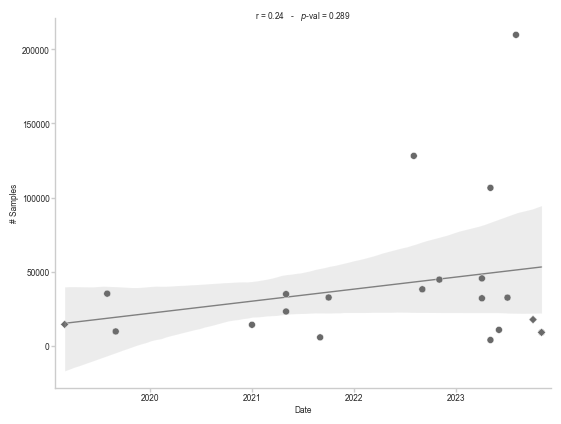

In [75]:
def plot_property_vs_property(prop, prop2, ax=None, size=None):    
    df_combined = df_properties.set_index('Method')[[prop, prop2]]
    df_combined['Type'] = df_combined.index.map(lambda x: 'Categorical' if x in ['MixTCRpred', 'TCRGP', 'NetTCR-Cat']
                                               else 'General')
    
    plot = sb.scatterplot(data=df_combined, x=prop, y=prop2,
                         size='Type', sizes={'General': size, 'Categorical': size-7},
                         style='Type', markers={'General': 'o', 'Categorical': 'D'},
                         color='dimgrey', ax=ax)
    plot = sb.regplot(data=df_combined, 
                      x=prop, y=prop2,
                      color='gray', ax=ax, 
                      scatter=False, line_kws={'zorder': -1, 'linewidth': utils_plot.LINEWIDTH})
    
    delta = df_combined[prop].max() - df_combined[prop].min()
    plot.set_xlim(df_combined[prop].min()-0.02*delta, df_combined[prop].max()+0.02*delta,)
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.spines['left'].set_linewidth(utils_plot.LINEWIDTH)
    plot.spines['bottom'].set_linewidth(utils_plot.LINEWIDTH)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, left=True, bottom=True)
    plot.set_ylabel(prop2, labelpad=2)
    plot.set_xlabel(prop, labelpad=2)
    plot.legend().remove()
    
    corr, p_val = pearsonr(df_combined[prop].values, df_combined[prop2].values)
    print(p_val)
    plot.set_title(f'r = {corr:.2f}   -   $p$-val = {p_val:.3f}', pad=0)
    
plot_property_vs_property('Date', '# Samples', size=25)

Palette 'Austria' has '7' discrete colors


C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\2820641232.py:23: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  plot = sb.swarmplot(data=df_combined, hue=prop, y='Value',
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\2820641232.py:31: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sb.scatterplot(x=xs, y=ys, ax=ax, hue=df_combined[prop], palette=palette_cats[prop],


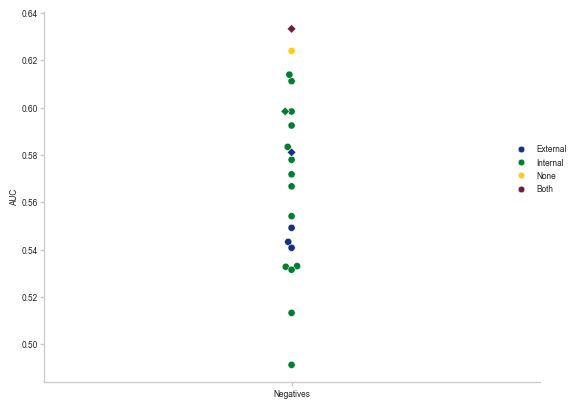

In [76]:
palette_cats = {
    'Network Type': met_brewer.met_brew(name="Austria", n=6, brew_type="continuous"),
    'Pretraining': {True: 'goldenrod', False: 'silver'},
    'Negatives': met_brewer.met_brew(name="Austria")[1:],
    'CDR3':  met_brewer.met_brew(name="NewKingdom", n=2, brew_type="continuous"),
    'Gene Usage': {'True': 'goldenrod', 'False': 'silver', 'Full TCR': 'peru', 'CDR1-2': 'gold'},
    'MHC': {True: 'goldenrod', False: 'silver'},
    'Representation': met_brewer.met_brew(name="VanGogh2", n=4, brew_type="continuous"),
}

def plot_property_vs_performance_cat(prop, metric, ax=None):
    df_scores = df_performance_best[df_performance_best['Metric']==metric]
    df_scores = df_scores[df_scores['Group']=='Average'].set_index('BaseModel')[['Value']]
    df_scores.index = df_scores.index.map(utils_config.mapper_methods)
    
    df_props = df_properties.set_index('Method')[[prop]]
    df_combined = pd.concat([df_scores, df_props], axis=1).fillna(0)
    df_combined['Type'] = df_combined.index.map(lambda x: 'Categorical' if x in ['MixTCRpred', 'NetTCR-Cat', 'TCRGP'] 
                                                else 'General')
    
    
    markers = ['D' if el == 'Categorical' else 'o' for el in df_combined['Type']]
    plot = sb.swarmplot(data=df_combined, hue=prop, y='Value', 
                        palette=palette_cats[prop], size=5, ax=ax)

    coords = plot.collections[0].get_offsets()
    xs = [el[0]/0.125 for el in coords]
    ys = [el[1] for el in coords]
    
    plot.clear()
    sb.scatterplot(x=xs, y=ys, ax=ax, hue=df_combined[prop], palette=palette_cats[prop],
                   size=df_combined['Type'], sizes={'General': 27, 'Categorical': 20},
                   style=df_combined['Type'], markers={'General': 'o', 'Categorical': 'D'})

    plot.set_xlim(-0.5, 0.5)
    plot.set_xticks([0])
    plot.set_xticklabels([])
    
    sb.despine(ax=plot)
    plot.grid(False)
    plot.spines['left'].set_linewidth(utils_plot.LINEWIDTH)
    plot.spines['bottom'].set_linewidth(utils_plot.LINEWIDTH)
    plot.tick_params(axis='both', pad=1, color=plot.spines["bottom"].get_edgecolor(),
                     length=3, width=1, bottom=True, left=prop in ['Network Type', 'Negatives'])
    plot.set_ylabel(metric, labelpad=2)
    plot.set_xlabel(prop, labelpad=2)
    
    handles, labels = plot.get_legend_handles_labels()
    filtered = [(h, l) for h, l in zip(handles, labels) if l not in ['Categorical', 'General', prop, 'Type']]
    plot.legend(*zip(*filtered), 
                loc='lower center', bbox_to_anchor=(1.0, 0.5), frameon=False, title=None, borderaxespad=0)

    
plot_property_vs_performance_cat('Negatives', 'AUC')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.28922681551535545
0.5233473439323659


C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\2820641232.py:23: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plot = sb.swarmplot(data=df_combined, hue=prop, y='Value',
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\2820641232.py:31: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sb.scatterplot(x=xs, y=ys, ax=ax, hue=df_combined[prop], palette=palette_cats[prop],
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\2820641232.py:23: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  plot = sb.swarmplot(data=df_combined, hue=prop, y='Value',
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_4076\2820641232.py:31: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sb.scatterplot(x=xs, y=ys, ax=ax, hue=df_combined[prop]

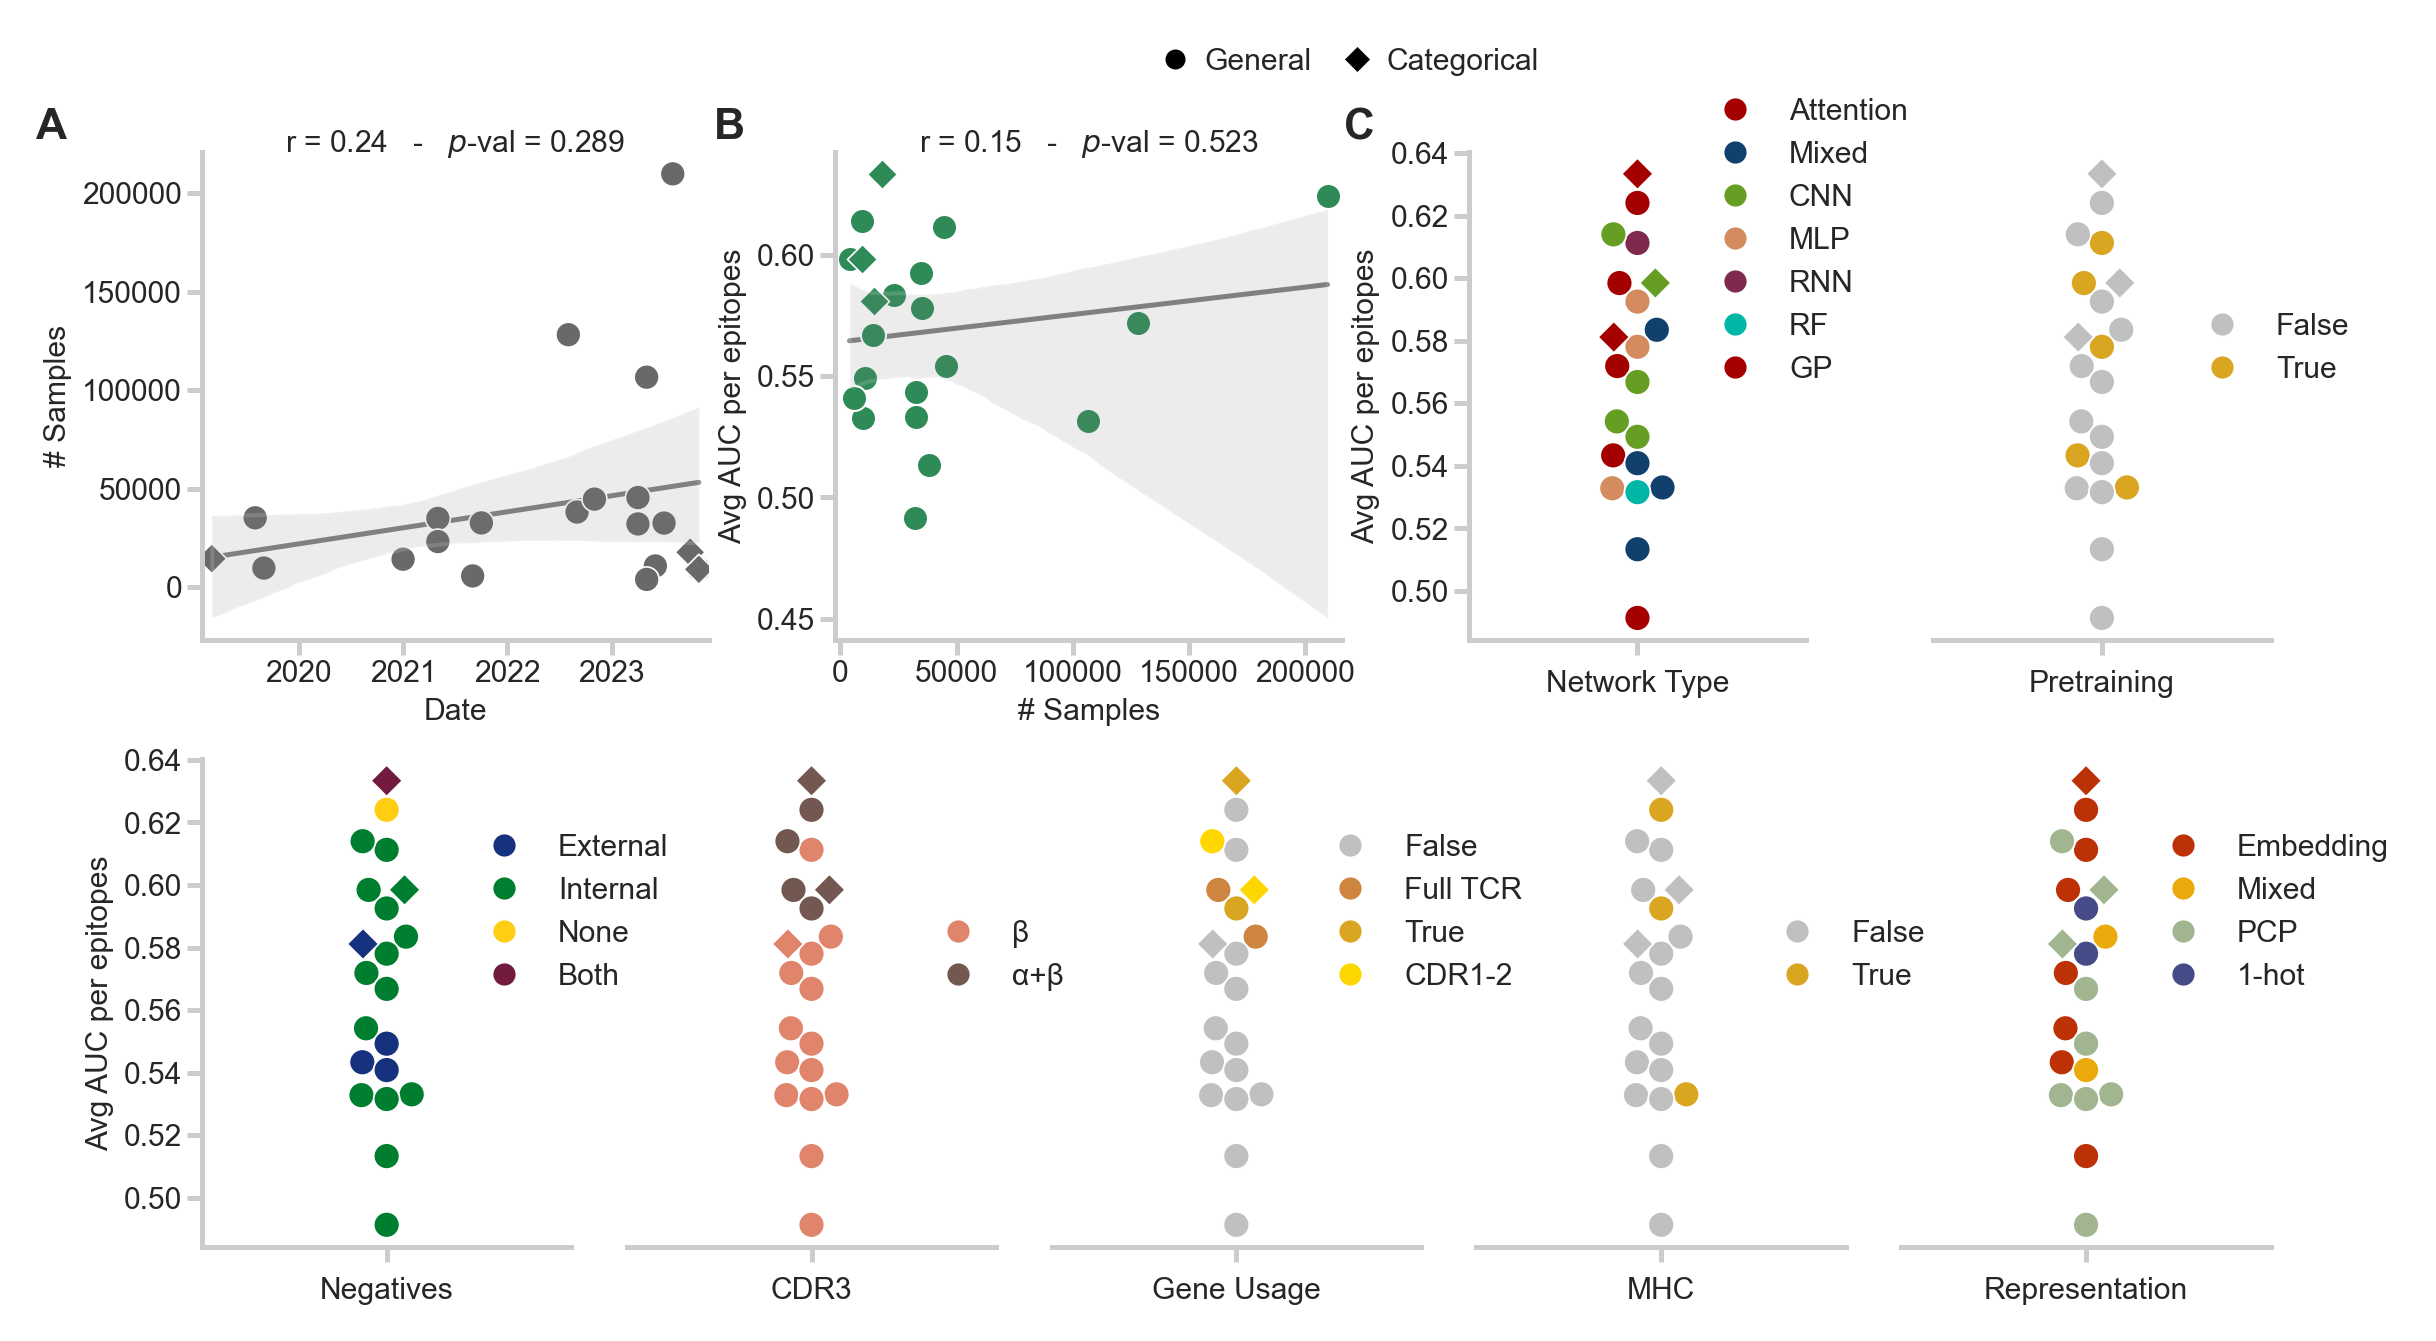

In [77]:
scale = 1
fig = plt.figure(figsize=(TEXT_WIDTH * scale, TEXT_WIDTH * scale * 0.55),
                 dpi=DPI)
set_font_size(6)
utils_plot.LINEWIDTH = 1

gridspecs = {}

gridspecs["full"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=1,
    height_ratios=[1, 1],
    width_ratios=[1],
)
gridspecs["top"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['full'][0],
    nrows=1,
    ncols=4,
    height_ratios=[1],
    width_ratios=[1.5, 1.5, 1, 1],
    wspace=0.30
)
gridspecs["bottom"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['full'][1],
    nrows=1,
    ncols=5,
    height_ratios=[1],
    width_ratios=[1, 1, 1, 1, 1],
    wspace=0.15
)

ax_a = fig.add_subplot(gridspecs["top"][0])
plot_property_vs_property('Date', '# Samples', ax=ax_a, size=25)

ax_b = fig.add_subplot(gridspecs["top"][1])
plot_property_vs_performance('# Samples', 'AUC', ax=ax_b, size=25)
ax_b.set_ylabel('Avg AUC per epitopes')

legend_handles = [
    Line2D([0], [0], marker='o', color='black', label='General',
           markersize=3, linestyle='None'),
    Line2D([0], [0], marker='D', color='black', label='Categorical',
           markersize=2.5, linestyle='None'),
]
ax_b.legend(handles=legend_handles, columnspacing=0.5, handletextpad=0., frameon=False, ncols=2,
           loc='lower center', bbox_to_anchor=(1.0, 1.1),)

for i, col in enumerate(reversed(['Network Type', 'Pretraining'])):
    ax = fig.add_subplot(gridspecs["top"][3-i])
    plot_property_vs_performance_cat(col, 'AUC', ax)
    if i != 1:
        sb.despine(ax=ax, left=True)
        ax.set_ylabel(None)
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Avg AUC per epitopes')
                        
                        
for i, col in enumerate(reversed(['Negatives', 'CDR3', 'Gene Usage', 'MHC', 'Representation'])):
    ax = fig.add_subplot(gridspecs["bottom"][4-i])
    plot_property_vs_performance_cat(col, 'AUC', ax)
    
    if i != 4: 
        sb.despine(ax=ax, left=True)
        ax.set_ylabel(None)
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Avg AUC per epitopes')
        
fig.text(0.01, 0.9, 'A', size='x-large', weight='bold')
fig.text(0.29, 0.9, 'B', size='x-large', weight='bold')
fig.text(0.55, 0.9, 'C', size='x-large', weight='bold')

fig.tight_layout()
fig.savefig('../figures/sfig_viral_properties.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/sfig_viral_properties.png', dpi=DPI, bbox_inches='tight')
plt.show()

## To Latex Table

In [78]:
from utils_latex import to_print_df, to_latex_string

In [79]:
df_performance_best[(df_performance_best['Metric']=='Rank')
                   & (~df_performance_best['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
                   ].groupby('Method')['Value'].mean().sort_values()

Method
stapler                      5.899576
nettcr_t.1.v.0               5.971371
teinet_SMALL_DS              6.040286
teim                         6.247780
ergo-i_AE_VDJDB              6.356140
tulip-tcr                    6.415317
mixtcrpred                   6.514049
titan                        6.711701
ergo-ii_VDJDB                6.779642
dlptcr_BETA                  6.854971
atm-tcr                      6.861317
pmtnet                       6.933753
imrex_FULL                   7.118301
nettcrcat_peptide_t.0.v.1    7.167975
tcrgp                        7.216028
itcep                        7.226131
attntap_VDJDB                7.285048
bertrand                     7.354024
epitcr_WITH_MHC              7.460182
tcellmatch_LINEAR_CV1        7.500000
panpep                       7.598782
Name: Value, dtype: float64

In [80]:
df_performance_best[(df_performance_best['Metric']=='Rank')
                   & (df_performance_best['Value']==1.0)]

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant,Group_short
2184,tcellmatch_LINEAR_CV1,Viral,NYNYLYRLF,116,MPS,Rank,1.0,tcellmatch,LINEAR_CV1,NYN
2769,ergo-ii_VDJDB,Viral,AYAQKIFKI,9,MPS,Rank,1.0,ergo-ii,VDJDB,AYA
3879,attntap_VDJDB,Viral,NLVPMVATV,5,MPS,Rank,1.0,attntap,VDJDB,NLV
6783,nettcrcat_peptide_t.0.v.1,Viral,NLVPMVATV,5,MPS,Rank,1.0,nettcrcat,peptide_t.0.v.1,NLV


In [81]:
metrics = ['AUC', 'APS', 'F1-Score', 'Rank', 'R@1', 'R@3']
df_print = to_print_df(df_performance_best, metrics, n_top=3)
df_print

Full Data                                \
                               AUC            APS       F1-Score   
ATM-TCR              \textbf{0.59}           0.09           0.16   
AttnTAP                       0.48           0.07           0.14   
BERTrand                      0.55           0.09  \textbf{0.21}   
DLpTCR                        0.53           0.08           0.14   
epiTCR                        0.58           0.08           0.17   
ERGO                          0.51           0.09           0.13   
ERGO-II                       0.52           0.09           0.14   
ImRex                         0.49           0.08           0.13   
iTCep                         0.39           0.05           0.13   
\textbf{MixTCRpred}          0.69*          0.40*          0.40*   
NetTCR-2.2                    0.56           0.11           0.15   
\textbf{NetTCR-Cat}          0.86*          0.35*          0.44*   
PanPep                        0.54           0.09           0.16   
pMTnet                        0.52           0.08           0.14   
STAPLER              \textbf{0.58}  \textbf{0.15}           0.16   
TCellMatch                    0.45           0.08           0.18   
\textbf{TCRGP}               0.87*          0.68*          0.74*   
TEIM                          0.53           0.14           0.15   
TEINet                        0.57  \textbf{0.19}  \textbf{0.19}   
TITAN                         0.40           0.07           0.13   
TULIP-TCR            \textbf{0.63}  \textbf{0.25}  \textbf{0.26}   

                                                                  \
                              Rank            R@1            R@3   
ATM-TCR              \textbf{6.28}           0.08           0.28   
AttnTAP                       7.80           0.02           0.04   
BERTrand                      6.92           0.07  \textbf{0.43}   
DLpTCR               \textbf{6.20}           0.13           0.30   
epiTCR                        6.46           0.01           0.18   
ERGO                          7.45           0.09           0.25   
ERGO-II                       7.35           0.03           0.28   
ImRex                         7.68           0.09           0.24   
iTCep                         8.93           0.02           0.10   
\textbf{MixTCRpred}          3.18*          0.41*          0.61*   
NetTCR-2.2                    7.02           0.13           0.23   
\textbf{NetTCR-Cat}          1.35*          0.81*          0.95*   
PanPep                        6.59           0.13  \textbf{0.32}   
pMTnet                        7.27           0.08           0.24   
STAPLER                       6.42           0.13           0.31   
TCellMatch                    8.11  \textbf{0.18}           0.21   
\textbf{TCRGP}               1.38*          0.78*          0.97*   
TEIM                          7.03           0.12           0.26   
TEINet                        6.81  \textbf{0.16}           0.32   
TITAN                         8.88           0.09           0.16   
TULIP-TCR            \textbf{6.00}  \textbf{0.26}  \textbf{0.44}   

                            Per Epitope                      \
                                    AUC                 APS   
ATM-TCR                       0.57±0.16           0.13±0.13   
AttnTAP                       0.51±0.16           0.12±0.16   
BERTrand                      0.54±0.12           0.12±0.13   
DLpTCR                        0.54±0.11           0.08±0.08   
epiTCR                        0.53±0.07           0.07±0.08   
ERGO                          0.58±0.09           0.13±0.14   
ERGO-II                       0.59±0.11           0.13±0.12   
ImRex                         0.57±0.15           0.12±0.12   
iTCep                         0.55±0.12           0.11±0.14   
\textbf{MixTCRpred}  \textbf{0.63±0.17}  \textbf{0.25±0.28}   
NetTCR-2.2           \textbf{0.61±0.17}           0.17±0.22   
\textbf{NetTCR-Cat}           0.60±0.18           0.18±0.24   
PanPep       

In [82]:
to_latex_string(df_print)

\begin{table}[ht]
\resizebox{\textwidth}{!}{%}
\centering
\begin{tabular}{l l l l l l l | l l l l l l}
\toprule
 & Full Data &   &   &   &   &   & Per Epitope &   &   &   &   &   \\
  & AUC & APS & F1-Score & Rank & R@1 & R@3 & AUC & APS & F1-Score & Rank & R@1 & R@3 \\
\midrule
ATM-TCR & \textbf{0.59} & 0.09 & 0.16 & \textbf{6.28} & 0.08 & 0.28 & 0.57±0.16 & 0.13±0.13 & 0.15±0.14 & 6.86±2.01 & 0.09±0.11 & 0.26±0.18 \\
AttnTAP & 0.48 & 0.07 & 0.14 & 7.80 & 0.02 & 0.04 & 0.51±0.16 & 0.12±0.16 & 0.10±0.13 & 7.29±4.20 & 0.10±0.29 & 0.21±0.43 \\
BERTrand & 0.55 & 0.09 & \textbf{0.21} & 6.92 & 0.07 & \textbf{0.43} & 0.54±0.12 & 0.12±0.13 & 0.06±0.13 & 7.35±4.05 & 0.08±0.26 & 0.21±0.42 \\
DLpTCR & 0.53 & 0.08 & 0.14 & \textbf{6.20} & 0.13 & 0.30 & 0.54±0.11 & 0.08±0.08 & 0.13±0.13 & 6.85±2.40 & 0.12±0.15 & 0.25±0.21 \\
epiTCR & 0.58 & 0.08 & 0.17 & 6.46 & 0.01 & 0.18 & 0.53±0.07 & 0.07±0.08 & 0.08±0.13 & 7.46±4.13 & 0.05±0.18 & 0.20±0.35 \\
ERGO & 0.51 & 0.09 & 0.13 & 7.45 & 0.09 & 0.25 & 0.

### Additional metrics

In [83]:
(df_performance_best[
    (~df_performance_best['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
    & (df_performance_best['Metric']=='AUC')
].groupby('BaseModel')['Value'].mean()<0.55).sum()

8

In [84]:
models_bad = (df_performance_best[
    (~df_performance_best['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
    & (df_performance_best['Metric']=='AUC')
].groupby('BaseModel')['Value'].mean()<0.55)
models_bad = models_bad[models_bad].index.tolist()
models_bad

['attntap',
 'bertrand',
 'dlptcr',
 'epitcr',
 'itcep',
 'panpep',
 'pmtnet',
 'tcellmatch']

In [85]:
outliers = df_performance_best[
    (~df_performance_best['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
    & (df_performance_best['Metric']=='AUC')
    & (df_performance_best['BaseModel'].isin(models_bad))
    & (df_performance_best['Value'] >= 0.7)
]
print(outliers['Group'].value_counts())
print()
print(outliers['BaseModel'].value_counts())

Group
YLQPRTFLL    3
GILGFVFTL    2
RLQSLQTYV    2
NYNYLYRLF    1
CTELKLSDY    1
Name: count, dtype: int64

BaseModel
attntap       2
bertrand      1
pmtnet        1
panpep        1
itcep         1
tcellmatch    1
epitcr        1
dlptcr        1
Name: count, dtype: int64


In [86]:
df_performance_best[
 (df_performance_best['BaseModel'].isin(models_bad)) &
    (~df_performance_best['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
    & (df_performance_best['Metric']=='AUC')
].groupby('BaseModel')['Value'].mean()

BaseModel
attntap       0.513319
bertrand      0.543320
dlptcr        0.540816
epitcr        0.531559
itcep         0.549261
panpep        0.491352
pmtnet        0.533070
tcellmatch    0.532807
Name: Value, dtype: float64

In [87]:
df_tmp = df_performance_best[
    (df_performance_best['BaseModel'].isin(models_bad)) &
    (~df_performance_best['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
    & (df_performance_best['Metric']=='AUC')]
df_tmp.groupby('BaseModel')['Value'].max()

BaseModel
attntap       0.920723
bertrand      0.751464
dlptcr        0.717147
epitcr        0.743012
itcep         0.814681
panpep        0.701843
pmtnet        0.712554
tcellmatch    0.722046
Name: Value, dtype: float64

In [88]:
df_tmp = df_performance_best[
    (df_performance_best['BaseModel'].isin(['attntap'])) &
    (~df_performance_best['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
    & (df_performance_best['Metric']=='AUC')]
df_tmp

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant,Group_short
3923,attntap_VDJDB,Viral,AYAQKIFKI,638,TTP,AUC,0.444444,attntap,VDJDB,AYA
3925,attntap_VDJDB,Viral,GILGFVFTL,638,TTP,AUC,0.814338,attntap,VDJDB,GIL
3927,attntap_VDJDB,Viral,YLQPRTFLL,638,TTP,AUC,0.920723,attntap,VDJDB,YLQ
3929,attntap_VDJDB,Viral,YVLDHLIVV,638,TTP,AUC,0.388449,attntap,VDJDB,YVL
3931,attntap_VDJDB,Viral,LTDEMIAQY,638,TTP,AUC,0.493748,attntap,VDJDB,LTD
3933,attntap_VDJDB,Viral,QYIKWPWYI,638,TTP,AUC,0.459020,attntap,VDJDB,QYI
3935,attntap_VDJDB,Viral,RLQSLQTYV,638,TTP,AUC,0.460707,attntap,VDJDB,RLQ
3937,attntap_VDJDB,Viral,SPRRARSVA,638,TTP,AUC,0.483499,attntap,VDJDB,SPR
3939,attntap_VDJDB,Viral,TYGPVFMCL,638,TTP,AUC,0.558280,attntap,VDJDB,TYG
3941,attntap_VDJDB,Viral,NLVPMVATV,638,TTP,AUC,0.311374,attntap,VDJDB,NLV


In [89]:
df_performance_best[
    (df_performance_best['Group']=='YLQPRTFLL')
    & (df_performance_best['Metric']=='AUC')
].sort_values('Value', ascending=False).head(5)

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant,Group_short
459,teim,Viral,YLQPRTFLL,638,TTP,AUC,0.976751,teim,,YLQ
7393,tcrgp,Viral,YLQPRTFLL,638,TTP,AUC,0.965074,tcrgp,,YLQ
3315,teinet_SMALL_DS,Viral,YLQPRTFLL,638,TTP,AUC,0.959149,teinet,SMALL_DS,YLQ
6161,mixtcrpred,Viral,YLQPRTFLL,638,TTP,AUC,0.958075,mixtcrpred,,YLQ
4029,tulip-tcr,Viral,YLQPRTFLL,638,TTP,AUC,0.953293,tulip-tcr,,YLQ


In [90]:
df_performance_best[
    (~df_performance_best['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
    & (df_performance_best['Metric']=='AUC')
].groupby('BaseModel')['Value'].mean().sort_values(ascending=False).head(6).index.tolist()

['mixtcrpred', 'tulip-tcr', 'nettcr', 'teinet', 'nettcrcat', 'stapler']

In [91]:
df_performance_best[
    (~df_performance_best['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
    & (df_performance_best['Metric']=='APS')
].groupby('BaseModel')['Value'].mean().sort_values(ascending=False).head(6).index.tolist()

['mixtcrpred', 'tulip-tcr', 'teinet', 'stapler', 'tcrgp', 'nettcrcat']

In [92]:
df_performance_best[
    (~df_performance_best['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
    & (df_performance_best['Metric']=='F1-Score')
].groupby('BaseModel')['Value'].mean().sort_values(ascending=False).head(6).index.tolist()

['mixtcrpred', 'tcrgp', 'nettcrcat', 'teinet', 'atm-tcr', 'tulip-tcr']

In [93]:
df_performance_best[
    (~df_performance_best['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
    & (df_performance_best['Metric']=='R@1')
].groupby('BaseModel')['Value'].mean().sort_values(ascending=False).head(5).index.tolist()

['mixtcrpred', 'tulip-tcr', 'nettcrcat', 'nettcr', 'stapler']

In [94]:
df_performance_best[
    (~df_performance_best['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
    & (df_performance_best['Metric']=='AUC')
].groupby('Group')['Value'].max()>=0.75

Group
AYAQKIFKI     True
CTELKLSDY    False
FPQSAPHGV    False
GILGFVFTL     True
KCYGVSPTK    False
LTDEMIAQY    False
NLVPMVATV     True
NYNYLYRLF    False
QYIKWPWYI    False
RLQSLQTYV    False
SPRRARSVA    False
TYGPVFMCL    False
YLQPRTFLL     True
YVLDHLIVV     True
Name: Value, dtype: bool

In [95]:
df_performance_best[
    (~df_performance_best['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
    & (df_performance_best['Metric']=='AUC')
].groupby('Group')['Value'].max()<=0.7

Group
AYAQKIFKI    False
CTELKLSDY    False
FPQSAPHGV     True
GILGFVFTL    False
KCYGVSPTK     True
LTDEMIAQY    False
NLVPMVATV    False
NYNYLYRLF    False
QYIKWPWYI     True
RLQSLQTYV    False
SPRRARSVA     True
TYGPVFMCL     True
YLQPRTFLL    False
YVLDHLIVV    False
Name: Value, dtype: bool

### Stats Prediction scores

In [96]:
(prediction_scores[['Epitope'] + prediction_scores.columns.tolist()[-21:]
                 ].groupby('Epitope').mean()>0.5).sum()

atm-tcr                      12
attntap_VDJDB                 3
bertrand                      0
dlptcr_BETA                  14
epitcr_WITH_MHC              13
ergo-i_AE_VDJDB               0
ergo-ii_VDJDB                 4
imrex_FULL                    1
itcep                         8
mixtcrpred                    7
nettcr_t.1.v.0                0
nettcrcat_peptide_t.0.v.1     0
panpep                        5
pmtnet                        7
stapler                       0
tcellmatch_LINEAR_CV1         6
tcrgp                         0
teim                          0
teinet_SMALL_DS               0
titan                         3
tulip-tcr                     0
dtype: int64

In [97]:
(prediction_scores[prediction_scores.columns.tolist()[-21:]
                 ].mean()>0.5).sum()

5

In [98]:
df_data['Epitope'].value_counts(normalize=True)

Epitope
LTDEMIAQY    0.202194
KCYGVSPTK    0.199060
NYNYLYRLF    0.181818
QYIKWPWYI    0.178683
YLQPRTFLL    0.076803
SPRRARSVA    0.048589
CTELKLSDY    0.021944
GILGFVFTL    0.020376
TYGPVFMCL    0.015674
AYAQKIFKI    0.014107
FPQSAPHGV    0.014107
YVLDHLIVV    0.009404
RLQSLQTYV    0.009404
NLVPMVATV    0.007837
Name: proportion, dtype: float64

In [99]:
prediction_scores[['Epitope', 'Label']].groupby('Epitope')['Label'].std().sort_values()

Epitope
NLVPMVATV    0.088248
RLQSLQTYV    0.096595
YVLDHLIVV    0.096595
FPQSAPHGV    0.118023
AYAQKIFKI    0.118023
TYGPVFMCL    0.124308
GILGFVFTL    0.141394
CTELKLSDY    0.146614
SPRRARSVA    0.215177
YLQPRTFLL    0.266487
QYIKWPWYI    0.383388
NYNYLYRLF    0.385997
KCYGVSPTK    0.399606
LTDEMIAQY    0.401952
Name: Label, dtype: float64

In [100]:
prediction_scores[['Epitope'] + prediction_scores.columns.tolist()[-21:]
                 ].groupby('Epitope').std().mean()<0.1

atm-tcr                      False
attntap_VDJDB                 True
bertrand                      True
dlptcr_BETA                  False
epitcr_WITH_MHC               True
ergo-i_AE_VDJDB              False
ergo-ii_VDJDB                False
imrex_FULL                   False
itcep                        False
mixtcrpred                   False
nettcr_t.1.v.0               False
nettcrcat_peptide_t.0.v.1    False
panpep                       False
pmtnet                       False
stapler                      False
tcellmatch_LINEAR_CV1         True
tcrgp                        False
teim                         False
teinet_SMALL_DS              False
titan                        False
tulip-tcr                    False
dtype: bool

In [101]:
prediction_scores[['Epitope'] + prediction_scores.columns.tolist()[-21:]
                 ].groupby('Epitope').mean().mean()<0.2

atm-tcr                      False
attntap_VDJDB                False
bertrand                     False
dlptcr_BETA                  False
epitcr_WITH_MHC              False
ergo-i_AE_VDJDB               True
ergo-ii_VDJDB                False
imrex_FULL                   False
itcep                        False
mixtcrpred                   False
nettcr_t.1.v.0                True
nettcrcat_peptide_t.0.v.1     True
panpep                       False
pmtnet                       False
stapler                       True
tcellmatch_LINEAR_CV1        False
tcrgp                        False
teim                          True
teinet_SMALL_DS               True
titan                        False
tulip-tcr                     True
dtype: bool

In [102]:
['mixtcrpred', 'tulip-tcr', 'nettcrcat', 'nettcr', 'stapler', 'teinet']

['mixtcrpred', 'tulip-tcr', 'nettcrcat', 'nettcr', 'stapler', 'teinet']

## Latex Table: AUC per predictor

In [103]:
epitope_groups = {
    'YVLDHLIVV': 'High',
    'GILGFVFTL': 'High',
    'NLVPMVATV': 'High',
    'YLQPRTFLL': 'High',
    'KCYGVSPTK': 'Medium',
    'QYIKWPWYI': 'Medium',
    'LTDEMIAQY': 'Medium',
    'CTELKLSDY': 'Medium',
    'RLQSLQTYV': 'Medium',
    'NYNYLYRLF': 'Medium',
    'AYAQKIFKI': 'Medium',
    'TYGPVFMCL': 'Low',
    'SPRRARSVA': 'Low',
    'FPQSAPHGV': 'Low'
}

In [104]:
df_print = df_performance_best[(df_performance_best['Metric']=='AUC')
                                & (~df_performance_best['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
            ]
df_print = df_print.pivot(index='BaseModel', columns='Group', values='Value')
df_print.columns.name = None
df_print.index.name = None
order = df_all_dbs.sort_values('CDR3', ascending=False).index.tolist()
df_print = df_print[order]

def format_column(col):
    top_3 = col.nlargest(3)  # Get top 3 values rounded to 2 decimals
    return col.apply(lambda x: f"\\textbf{{{round(x, 2):.02f}}}" if float(x) in top_3.values else f"{round(x,2):.02f}").astype(str)
df_print.index = df_print.index.map(utils_config.mapper_methods)
df_print.columns = pd.MultiIndex.from_tuples([(epitope_groups[el], el) for el in df_print.columns])

for col in ['High', 'Medium', 'Low']:
    df_print[(col, 'Avg')] = df_print[col].mean(axis=1)

order = [(epitope_groups[el], el) for el in order]
order.insert(4, ('High', 'Avg'))
order.insert(12, ('Medium', 'Avg'))
order.insert(16, ('Low', 'Avg'))

df_print = df_print[order]
df_print = df_print.apply(format_column)
df_print.loc[['MixTCRpred', 'NetTCR-Cat', 'TCRGP']] = df_print.loc[['MixTCRpred', 'NetTCR-Cat', 'TCRGP']].replace('0.50', '-')

df_print.index = ['\\textbf{' + el + '}' if el in ['MixTCRpred', 'NetTCR-Cat', 'TCRGP'] else el for el in df_print.index]
df_print

High                                \
                         YVLDHLIVV      GILGFVFTL      NLVPMVATV   
ATM-TCR              \textbf{0.75}           0.82           0.85   
AttnTAP                       0.39           0.81           0.31   
BERTrand                      0.60           0.67           0.60   
DLpTCR                        0.57           0.66           0.43   
epiTCR                        0.52           0.59           0.56   
ERGO                          0.62           0.68           0.67   
ERGO-II                       0.73           0.76           0.79   
ImRex                         0.45           0.77  \textbf{0.88}   
iTCep                         0.48           0.67           0.64   
\textbf{MixTCRpred}           0.68  \textbf{0.86}  \textbf{0.92}   
NetTCR-2.2                    0.35           0.82           0.86   
\textbf{NetTCR-Cat}              -  \textbf{0.87}  \textbf{0.96}   
PanPep                        0.55           0.41           0.65   
pMTnet                        0.46           0.71           0.54   
STAPLER                       0.61  \textbf{0.84}           0.87   
TCellMatch                    0.60           0.61           0.64   
\textbf{TCRGP}                0.64           0.77           0.76   
TEIM                          0.52           0.73           0.65   
TEINet               \textbf{0.85}           0.76           0.49   
TITAN                         0.60           0.82           0.24   
TULIP-TCR            \textbf{0.95}           0.79           0.65   

                                                          Medium  \
                         YLQPRTFLL            Avg      KCYGVSPTK   
ATM-TCR                       0.26           0.67           0.55   
AttnTAP                       0.92           0.61           0.42   
BERTrand                      0.75           0.65           0.54   
DLpTCR                        0.63           0.57           0.45   
epiTCR                        0.53           0.55           0.49   
ERGO                          0.45           0.60           0.50   
ERGO-II                       0.65           0.73           0.44   
ImRex                         0.37           0.62  \textbf{0.58}   
iTCep                         0.81           0.65           0.47   
\textbf{MixTCRpred}           0.96  \textbf{0.85}              -   
NetTCR-2.2                    0.93           0.74           0.53   
\textbf{NetTCR-Cat}           0.93  \textbf{0.82}              -   
PanPep                        0.43           0.51           0.38   
pMTnet                        0.54           0.57           0.51   
STAPLER                       0.93           0.81           0.49   
TCellMatch                    0.51           0.59  \textbf{0.56}   
\textbf{TCRGP}       \textbf{0.97}           0.78              -   
TEIM                 \textbf{0.98}           0.72           0.38   
TEINet               \textbf{0.96}           0.76           0.49   
TITAN                         0.91           0.64  \textbf{0.55}   
TULIP-TCR                     0.95  \textbf{0.84}           0.50   

                                                                  \
                         QYIKWPWYI      LTDEMIAQY      CTELKLSDY   
ATM-TCR                       0.55           0.58           0.37   
AttnTAP                       0.46           0.49           0.49   
BERTrand                      0.41           0.45           0.47   
DLpTCR                        0.56           0.50  \textbf{0.72}   
epiTCR                        0.47           0.47           0.53   
ERGO                          0.54           0.49           0.55   
ERGO-II                       0.54           0.54           0.49   
ImRex                         0.53           0.47           0.43   
iTCep                         0.47           0.51           0.43   
\textbf{MixTCRpred}           0.53  \textbf{0.70}           0.56   
NetTCR-2.2           \textbf{0.56}           0.49  \textbf{0.63}   
\textbf{NetTCR-C

In [105]:
def custom_2_latex(df):
    cols = ['l |'] + ['l']  * 5 + ['|'] + ['l'] * 8 + ['|'] + ['l'] * 4
    init = [r"\begin{table}[ht]",
            r"\resizebox{\textwidth}{!}{%}",
            r"\centering",
            r"\begin{tabular}{" + " ".join(cols) + "}",
            r"\toprule"]
    top_header = [""]
    for el in df.columns:
        top_header.append(el[0] if el[0] not in top_header else " ")
    header = [
        " & ".join(top_header) + " \\\\",
        " & ".join([" "] + [el[1][:3] for el in df.columns]) + " \\\\",
        '\midrule'
    ]
    body = [" & ".join([el.name] + el.values.tolist()) + " \\\\" for _, el in df.iterrows()]
    end = ["\\bottomrule",
           "\end{tabular}}",
           "\caption{\\textbf{}}",
           "\label{}",
           "\end{table}"]
    
    cmd =  init + header + body + end
    for line in cmd:
        print(line)
custom_2_latex(df_print)

\begin{table}[ht]
\resizebox{\textwidth}{!}{%}
\centering
\begin{tabular}{l | l l l l l | l l l l l l l l | l l l l}
\toprule
 & High &   &   &   &   & Medium &   &   &   &   &   &   &   & Low &   &   &   \\
  & YVL & GIL & NLV & YLQ & Avg & KCY & QYI & LTD & CTE & RLQ & NYN & AYA & Avg & TYG & SPR & FPQ & Avg \\
\midrule
ATM-TCR & \textbf{0.75} & 0.82 & 0.85 & 0.26 & 0.67 & 0.55 & 0.55 & 0.58 & 0.37 & 0.51 & 0.58 & 0.60 & 0.54 & 0.40 & 0.59 & 0.58 & 0.52 \\
AttnTAP & 0.39 & 0.81 & 0.31 & 0.92 & 0.61 & 0.42 & 0.46 & 0.49 & 0.49 & 0.46 & 0.46 & 0.44 & 0.46 & 0.56 & 0.48 & 0.49 & 0.51 \\
BERTrand & 0.60 & 0.67 & 0.60 & 0.75 & 0.65 & 0.54 & 0.41 & 0.45 & 0.47 & 0.34 & 0.65 & 0.54 & 0.49 & 0.53 & \textbf{0.68} & 0.38 & 0.53 \\
DLpTCR & 0.57 & 0.66 & 0.43 & 0.63 & 0.57 & 0.45 & 0.56 & 0.50 & \textbf{0.72} & 0.67 & 0.44 & 0.38 & 0.53 & 0.45 & 0.50 & \textbf{0.63} & 0.53 \\
epiTCR & 0.52 & 0.59 & 0.56 & 0.53 & 0.55 & 0.49 & 0.47 & 0.47 & 0.53 & \textbf{0.74} & 0.56 & 0.54 & 0.54 & 0.48 & 0.47

In [106]:
df_print = df_performance_best_cat[(df_performance_best_cat['Metric']=='AUC')
                                & (~df_performance_best_cat['Group'].isin(['full_data', 'Average', 'WeightedAverage']))
                                & (df_performance_best_cat['Support']>0)
            ]
df_print = df_print.pivot(index='BaseModel', columns='Group', values='Value')
df_print.columns.name = None
df_print.index.name = None
order = df_all_dbs.sort_values('CDR3', ascending=False).index.tolist()
for col in order:
    if col not in df_print.columns:
        df_print[col] = np.nan
df_print = df_print[order]

def format_column(col):
    top_3 = col.nlargest(1)  # Get top 3 values rounded to 2 decimals
    return col.apply(lambda x: f"\\textbf{{{round(x, 2):.02f}}}" if float(x) in top_3.values else f"{round(x,2):.02f}").astype(str)
df_print.index = df_print.index.map(utils_config.mapper_methods)
df_print.columns = pd.MultiIndex.from_tuples([(epitope_groups[el], el) for el in df_print.columns])

df_print = df_print.replace(np.nan, 0.5)
for col in ['High', 'Medium', 'Low']:
    mask = (df_print[col].isna().sum(axis=1)>0).values
    df_print[(col, 'Avg')] = df_print[col].mean(axis=1)
    df_print.loc[mask, (col, 'Avg')] = -99
    
order = [(epitope_groups[el], el) for el in order]
order.insert(4, ('High', 'Avg'))
order.insert(12, ('Medium', 'Avg'))
order.insert(16, ('Low', 'Avg'))

df_print = df_print[order]

df_print = df_print.apply(format_column)
df_print = df_print.replace('nan', np.nan).fillna('-')
df_print = df_print.replace('0.50', '-')
df_print = df_print.replace('\\textbf{0.50}', '-')
df_print[('Low', 'Avg')] = '0.50'
df_print

High                                               \
                YVLDHLIVV      GILGFVFTL      NLVPMVATV      YLQPRTFLL   
MixTCRpred  \textbf{0.68}           0.86           0.92           0.96   
NetTCR-Cat              -  \textbf{0.87}  \textbf{0.96}           0.93   
TCRGP                0.64           0.77           0.76  \textbf{0.97}   

                             Medium                                \
                      Avg KCYGVSPTK      QYIKWPWYI      LTDEMIAQY   
MixTCRpred  \textbf{0.85}         -  \textbf{0.53}  \textbf{0.70}   
NetTCR-Cat           0.82         -              -              -   
TCRGP                0.78         -              -              -   

                                                                             \
                CTELKLSDY RLQSLQTYV      NYNYLYRLF AYAQKIFKI            Avg   
MixTCRpred           0.56         -  \textbf{0.66}         -  \textbf{0.56}   
NetTCR-Cat  \textbf{0.61}         -              -         -           0.52   
TCRGP                   -         -              -         -              -   

                 Low                            
           TYGPVFMCL SPRRARSVA FPQSAPHGV   Avg  
MixTCRpred         -         -         -  0.50  
NetTCR-Cat         -         -         -  0.50  
TCRGP              -         -         -  0.50

In [107]:
custom_2_latex(df_print)

\begin{table}[ht]
\resizebox{\textwidth}{!}{%}
\centering
\begin{tabular}{l | l l l l l | l l l l l l l l | l l l l}
\toprule
 & High &   &   &   &   & Medium &   &   &   &   &   &   &   & Low &   &   &   \\
  & YVL & GIL & NLV & YLQ & Avg & KCY & QYI & LTD & CTE & RLQ & NYN & AYA & Avg & TYG & SPR & FPQ & Avg \\
\midrule
MixTCRpred & \textbf{0.68} & 0.86 & 0.92 & 0.96 & \textbf{0.85} & - & \textbf{0.53} & \textbf{0.70} & 0.56 & - & \textbf{0.66} & - & \textbf{0.56} & - & - & - & 0.50 \\
NetTCR-Cat & - & \textbf{0.87} & \textbf{0.96} & 0.93 & 0.82 & - & - & - & \textbf{0.61} & - & - & - & 0.52 & - & - & - & 0.50 \\
TCRGP & 0.64 & 0.77 & 0.76 & \textbf{0.97} & 0.78 & - & - & - & - & - & - & - & - & - & - & - & 0.50 \\
\bottomrule
\end{tabular}}
\caption{\textbf{}}
\label{}
\end{table}


In [108]:
df_performance_best_cat[df_performance_best_cat['Group']=='Average']

,Method,Dataset,Group,Support,Metric_Type,Metric,Value,BaseModel,Variant
3780,mixtcrpred,Viral,Average,0,TTP,AUC,0.633323,mixtcrpred,
3781,mixtcrpred,Viral,Average,0,TTP,APS,0.251407,mixtcrpred,
3782,mixtcrpred,Viral,Average,0,TTP,R@1,0.255711,mixtcrpred,
3783,mixtcrpred,Viral,Average,0,TTP,R@3,0.400332,mixtcrpred,
3784,mixtcrpred,Viral,Average,0,TTP,F1-Score,0.234261,mixtcrpred,
3785,mixtcrpred,Viral,Average,0,TTP,Rank,6.514049,mixtcrpred,
3906,nettcrcat_peptide_t.0.v.1,Viral,Average,0,TTP,AUC,0.598448,nettcrcat,peptide_t.0.v.1
3907,nettcrcat_peptide_t.0.v.1,Viral,Average,0,TTP,APS,0.179329,nettcrcat,peptide_t.0.v.1
3908,nettcrcat_peptide_t.0.v.1,Viral,Average,0,TTP,R@1,0.236376,nettcrcat,peptide_t.0.v.1
3909,nettcrcat_peptide_t.0.v.1,Viral,Average,0,TTP,R@3,0.267773,nettcrcat,peptide_t.0.v.1
